# **F1 Pit Stop Prediction**

This project was developed using the **FastF1** library data and aims to predict if the driver will be going to the pits in the next lap.<br>
To collect the data, the team developed a `data_collection.py` script. This script allows the user to collect lap, telemetry and weather data.

The metadata of the datasets used in this project can be found at the **FastF1** documentation page, at https://docs.fastf1.dev/core.html. (Visited on May 10th, 2025)

## 0. Imports, Constants and Helper Functions

**Libraries**

In [0]:
# Import standard libraries
from pathlib import Path
import math

# Data manipulation
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import seaborn as sns

# PySpark session and core functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    regexp_replace, col, when, 
    lead, avg, lag, max, sum, first, last, split, coalesce, lit
)
from pyspark.sql.types import IntegerType, BooleanType
from pyspark.sql.window import Window

# PySpark ML Pipeline and feature engineering
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.functions import vector_to_array

# PySpark ML classifiers and evaluators
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Access built-in functions
import builtins

**Constants**

In [0]:
# Define constants

# Colors
BLUE = '#003773'
RED = '#ED1E36'
YELLOW = '#FABB23'
TEAM_COLORS = {
    'Red Bull Racing': BLUE
    ,'Mercedes': '#00A19B'
    ,'Ferrari': '#A6051A'
    ,'McLaren': '#FF8700'
    ,'Aston Martin': '#00665E'
    ,'Alpine': '#FD4BC7'
    ,'AlphaTauri': '#00293F'
    ,'Alfa Romeo': '#972738'
    ,'Haas F1 Team': '#AEAEAE'
    ,'Williams': '#00A3E0'
}

# Colormap
CMAP = (
    mcolors
    .LinearSegmentedColormap
    .from_list(
        "my_cmap"
        ,[BLUE, YELLOW, RED]
    )
)

COMPOUND_COLORS = {
    'SOFT': '#F20704'
    ,'MEDIUM': '#FACA08'
    ,'HARD': '#000000'
    ,'INTERMEDIATE': '#029405'
    ,'WET': '#078CD1'
}

# Plot constants
EVENT_PLT = 'British Grand Prix'
YEAR_PLT = 2023
DRIVER_PLT = 'VER'

# Features
LAP_METRIC = [
    'LapTime'
    ,'LapNumber'
    ,'Stint'
    ,'PitOutTime'
    ,'PitInTime'
    ,'Sector1Time'
    ,'Sector2Time'
    ,'Sector3Time'
    ,'SpeedI1'
    ,'SpeedI2'
    ,'SpeedFL'
    ,'SpeedST'
    ,'TyreLife'
    ,'LapStartTime'
    ,'LapSessionTime'
]
LAP_CATEGORICAL = [
    'Driver'
    ,'DriverNumber'
    ,'IsPersonalBest'
    ,'Compound'
    ,'FreshTyre'
    ,'Team'
    ,'TrackStatus'
    ,'Position'
    ,'Deleted'
    ,'FastF1Generated'
    ,'IsAccurate'
    ,'Year'
    ,'EventName'
    ,'Session'
]
TELEMETRY_METRIC = [
    'RPM'
    ,'Speed'
    ,'Throttle'
    ,'SessionTime'
    ,'Distance'
    ,'LapNumber'
]
TELEMETRY_CATEGORICAL = [
    'nGear'
    ,'Brake'
    ,'DRS'
    ,'Driver'
    ,'Year'
    ,'EventName'
    ,'Session'
    ,'IsDRSActive'
]
WEATHER_METRIC = [
    'Time'
    ,'AirTemp'
    ,'Humidity'
    ,'Pressure'
    ,'TrackTemp'
    ,'WindSpeed'
]
WEATHER_CATEGORICAL = [
    'Rainfall'
    ,'WindDirection'
    ,'Year'
    ,'EventName'
    ,'Session'
]

**Helper Functions**

In [0]:
# Define helper function for number of bins in histogram
def sturges_bins(data, column_name):
    """
    Calculates the number of bins for a histogram using Sturges' Rule.
    
    Parameters:
    data (pd.DataFrame): The dataset containing the column.
    column_name (str): The name of the column to calculate the number of bins for.
    
    Returns:
    int: The number of bins calculated using Sturges' Rule.
    """
    # Number of data points
    n = len(data[column_name])
    
    # Calculate the number of bins using Sturges' Rule
    k = int(np.ceil(np.log2(n) + 1))
    
    return k

In [0]:
def expand_one_hot_vectors(df, ohe_columns):
    """
    Expands one-hot encoded vector columns in a PySpark DataFrame into separate binary columns.

    Parameters:
    -----------
    df : pyspark.sql.DataFrame
        The input DataFrame containing one-hot encoded vector columns.
    
    ohe_columns : list of str
        List of column names containing one-hot encoded vectors (VectorUDT).

    Returns:
    --------
    pyspark.sql.DataFrame
        DataFrame with each one-hot encoded vector column expanded into individual binary columns.
        Intermediate array columns are dropped after expansion.
    """
    for vec_col in ohe_columns:
        # Convert vector column to array
        df = df.withColumn(f"{vec_col}_array", vector_to_array(col(vec_col)))
        # Get the length of the vector (i.e., number of categories)
        size = len(df.select(vec_col).first()[0])
        # Create a separate column for each category
        for i in range(size):
            df = df.withColumn(f"{vec_col}_{i}", col(f"{vec_col}_array")[i])
    # Drop the intermediate array columns
    return df.drop(*[f"{col}_array" for col in ohe_columns])


## 1. Data Loading

In this section, the spark session is initiliazed and the data is ingested.

In [0]:
# Initialize Spark Session
spark = (
    SparkSession.builder
    .appName("BDAProject")
    .getOrCreate()
)

### 1.1. Lap Data

In [0]:
# Load the data
lap_data = spark.table("laps")

#### 1.1.1. Feature Analysis

After analysing the available metadata, some features are removed from the dataframe, as they do not bring necessary value to the problem solution.

In [0]:
# Dropping irrelevant columns
lap_data = lap_data.drop(
    "Sector1SessionTime"
    ,"Sector2SessionTime"
    ,"Sector3SessionTime"
    ,"LapStartDate"
    ,"DeletedReason"
)

#### 1.1.2. Fixing Datatypes

In [0]:
# Check datatypes
lap_data.printSchema()

root
 |-- Time: string (nullable = true)
 |-- Driver: string (nullable = true)
 |-- DriverNumber: integer (nullable = true)
 |-- LapTime: string (nullable = true)
 |-- LapNumber: double (nullable = true)
 |-- Stint: double (nullable = true)
 |-- PitOutTime: string (nullable = true)
 |-- PitInTime: string (nullable = true)
 |-- Sector1Time: string (nullable = true)
 |-- Sector2Time: string (nullable = true)
 |-- Sector3Time: string (nullable = true)
 |-- SpeedI1: double (nullable = true)
 |-- SpeedI2: double (nullable = true)
 |-- SpeedFL: double (nullable = true)
 |-- SpeedST: double (nullable = true)
 |-- IsPersonalBest: boolean (nullable = true)
 |-- Compound: string (nullable = true)
 |-- TyreLife: double (nullable = true)
 |-- FreshTyre: boolean (nullable = true)
 |-- Team: string (nullable = true)
 |-- LapStartTime: string (nullable = true)
 |-- TrackStatus: integer (nullable = true)
 |-- Position: double (nullable = true)
 |-- Deleted: boolean (nullable = true)
 |-- FastF1Generat

In [0]:
# Fix datatypes
lap_data = (
    lap_data
    .withColumn("LapSessionTime", split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("LapTime", split(regexp_replace(col("LapTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("LapTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("LapTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("LapNumber", col("LapNumber").cast(IntegerType()))
    .withColumn("Stint", col("Stint").cast(IntegerType()))
    .withColumn("PitOutTime", split(regexp_replace(col("PitOutTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("PitOutTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("PitOutTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("PitInTime", split(regexp_replace(col("PitInTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("PitInTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("PitInTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Sector1Time", split(regexp_replace(col("Sector1Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Sector1Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Sector1Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Sector2Time", split(regexp_replace(col("Sector2Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Sector2Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Sector2Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Sector3Time", split(regexp_replace(col("Sector3Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Sector3Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Sector3Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("SpeedI1", col("SpeedI1").cast(IntegerType()))
    .withColumn("SpeedI2", col("SpeedI2").cast(IntegerType()))
    .withColumn("SpeedFL", col("SpeedFL").cast(IntegerType()))
    .withColumn("SpeedST", col("SpeedST").cast(IntegerType()))
    .withColumn("TyreLife", col("TyreLife").cast(IntegerType()))
    .withColumn("LapStartTime", split(regexp_replace(col("LapStartTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("LapStartTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("LapStartTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Position", col("Position").cast(IntegerType()))
    .withColumn("Year", col("Year").cast(IntegerType()))
)

lap_data = lap_data.drop(col("Time"))

In [0]:
# Show the result
display(lap_data.limit(1))

Driver DriverNumber LapTime LapNumber Stint PitOutTime PitInTime Sector1Time Sector2Time Sector3Time SpeedI1 SpeedI2 SpeedFL SpeedST IsPersonalBest Compound TyreLife FreshTyre Team LapStartTime TrackStatus Position Deleted FastF1Generated IsAccurate Year EventName Session LapSessionTime VER 1 99.019 1 1 null null null 42.414 23.842 232 231 278 252 false SOFT 4 false Red Bull Racing 3756.652 12 1 false false false 2023 Bahrain Grand Prix R 3855.902

### 1.2. Telemetry Data

In [0]:
# Load the data
telemetry_2023 = spark.table("telemetry_2023")
telemetry_2024_1 = spark.table("telemetry_2024_1")
telemetry_2024_2 = spark.table("telemetry_2024_2")

telemetry_data = (
    telemetry_2023
    .unionByName(telemetry_2024_1)
    .unionByName(telemetry_2024_2)
)

#### 1.2.1. Feature Analysis

After analysing the available metadata, some features are removed from the dataframe, as they do not bring necessary value to the problem solution.

In [0]:
telemetry_data = telemetry_data.drop(
    "Date"
    ,"DataCollectionTime"
    ,"Time"
    ,"Source"
)

#### 1.2.2. Fixing Datatypes

In [0]:
# Check datatypes
telemetry_data.printSchema()

root
 |-- RPM: double (nullable = true)
 |-- Speed: double (nullable = true)
 |-- nGear: integer (nullable = true)
 |-- Throttle: double (nullable = true)
 |-- Brake: boolean (nullable = true)
 |-- DRS: integer (nullable = true)
 |-- SessionTime: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Driver: string (nullable = true)
 |-- LapNumber: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- EventName: string (nullable = true)
 |-- Session: string (nullable = true)



In [0]:
telemetry_data = (
    telemetry_data
    .withColumn("RPM", col("RPM").cast(IntegerType()))
    .withColumn("Speed", col("Speed").cast(IntegerType()))
    .withColumn("Throttle", col("Throttle").cast(IntegerType()))
    .withColumn("Brake", col("Brake").cast(BooleanType()).cast(IntegerType()))
    .withColumn(
        "SessionTime", split(regexp_replace(col("SessionTime"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("SessionTime"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("SessionTime"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("LapNumber", col("LapNumber").cast(IntegerType()))
    .withColumn("Year", col("Year").cast(IntegerType()))
    .withColumn(
        "IsDRSActive", when(
            col("DRS").isin(10, 12, 14), 1
        ).otherwise(0)
    )
)

In [0]:
# Show the result
display(telemetry_data.limit(1))

RPM Speed nGear Throttle Brake DRS SessionTime Distance Driver LapNumber Year EventName Session IsDRSActive 10130 0 1 16 0 1 3756.762 0.0 VER 1 2023 Bahrain Grand Prix R 0

### 1.3. Weather Data

In [0]:
# Load the data
weather_data = spark.table("weather")

#### 1.3.1. Fixing Datatypes

In [0]:
# Check datatypes
weather_data.printSchema()

root
 |-- Time: string (nullable = true)
 |-- AirTemp: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- Rainfall: boolean (nullable = true)
 |-- TrackTemp: double (nullable = true)
 |-- WindDirection: integer (nullable = true)
 |-- WindSpeed: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- EventName: string (nullable = true)
 |-- Session: string (nullable = true)



In [0]:
weather_data = (
    weather_data
    .withColumn(
        "Time", split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(0).cast("int") * 3600 +
        split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(1).cast("int") * 60 +
        split(regexp_replace(col("Time"), r"^0 days ", ""), ":").getItem(2).cast("double")
    )
    .withColumn("Rainfall", col("Rainfall").cast(IntegerType()))
)

In [0]:
# Show the result
display(weather_data.limit(1))

Time AirTemp Humidity Pressure Rainfall TrackTemp WindDirection WindSpeed Year EventName Session 45.438 29.8 19.0 1016.5 0 35.1 176 1.2 2023 Bahrain Grand Prix R

## 2. Data Visualization

### 2.1. Lap Data

In [0]:
# Convert the dataframe to pandas for visualization purposes
lap_pd = lap_data.toPandas()

#### 2.1.1. Histograms

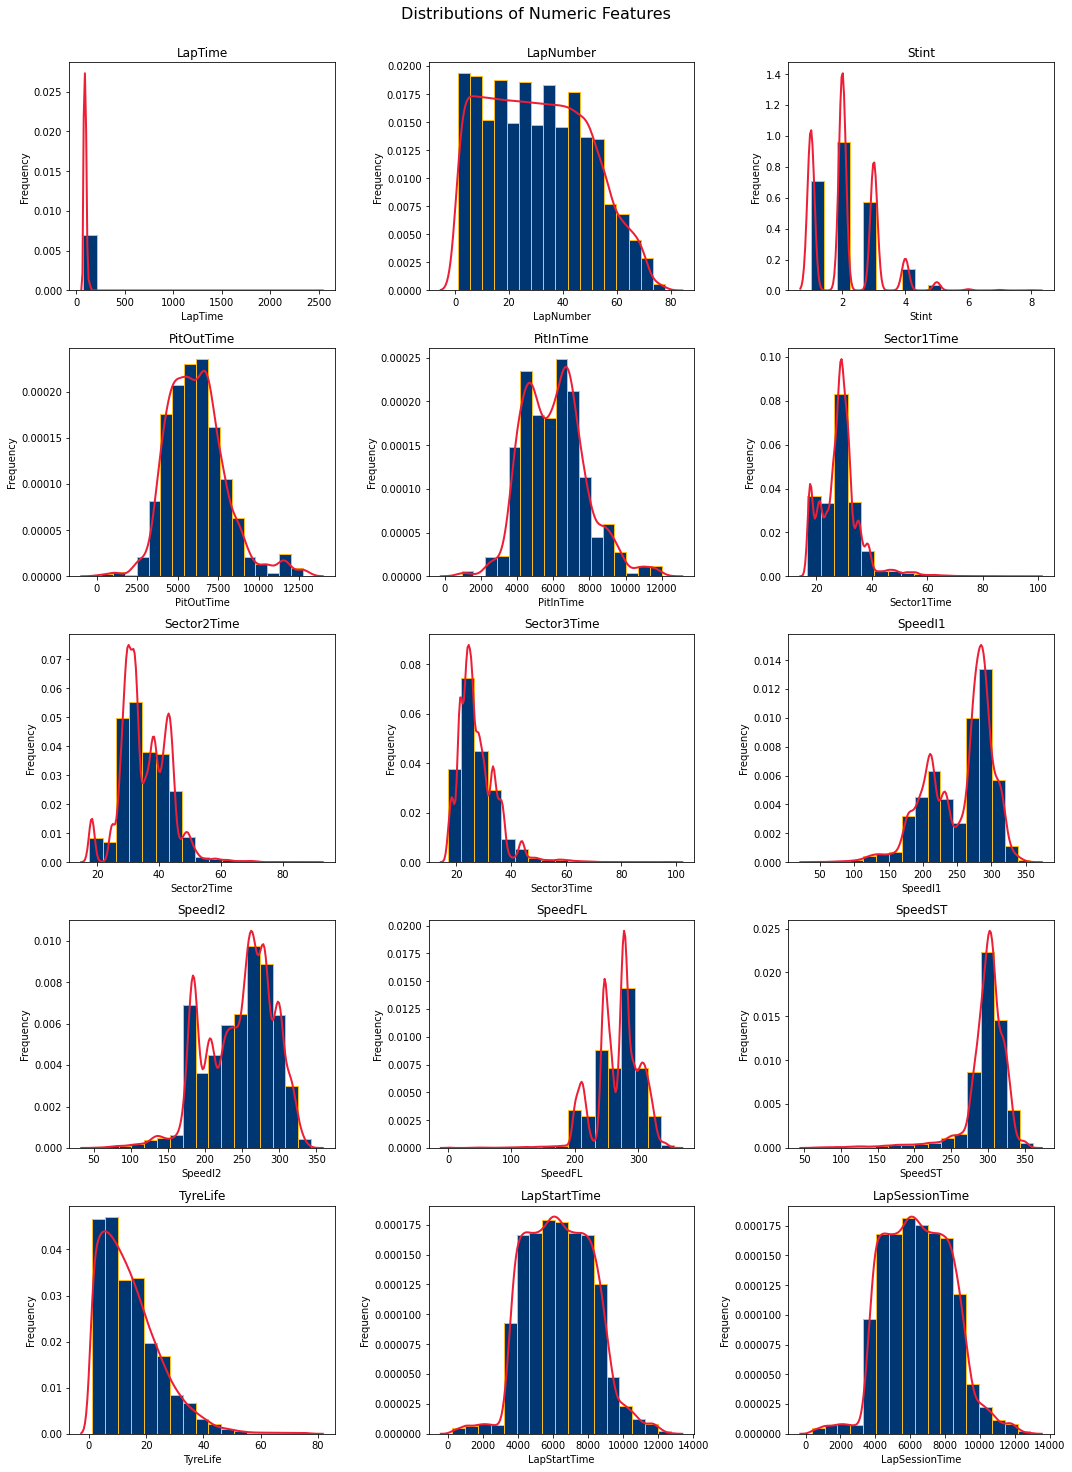

In [0]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(LAP_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot histogram and density line
for i, col_ in enumerate(LAP_METRIC):
    sns.histplot(
        data=lap_pd
        ,x=col_
        ,ax=axes[i]
        ,bins=sturges_bins(lap_pd, col_)
        ,color=BLUE
        ,edgecolor=YELLOW
        ,stat='density'
        ,alpha=1
    )

    sns.kdeplot(
        data=lap_pd
        ,x=col_
        ,ax=axes[i]
        ,color=RED
        ,linewidth=2
    )
    
    axes[i].set_title(col_)
    axes[i].set_xlabel(col_)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Numeric Features", fontsize=16, y=1.02)
plt.show()

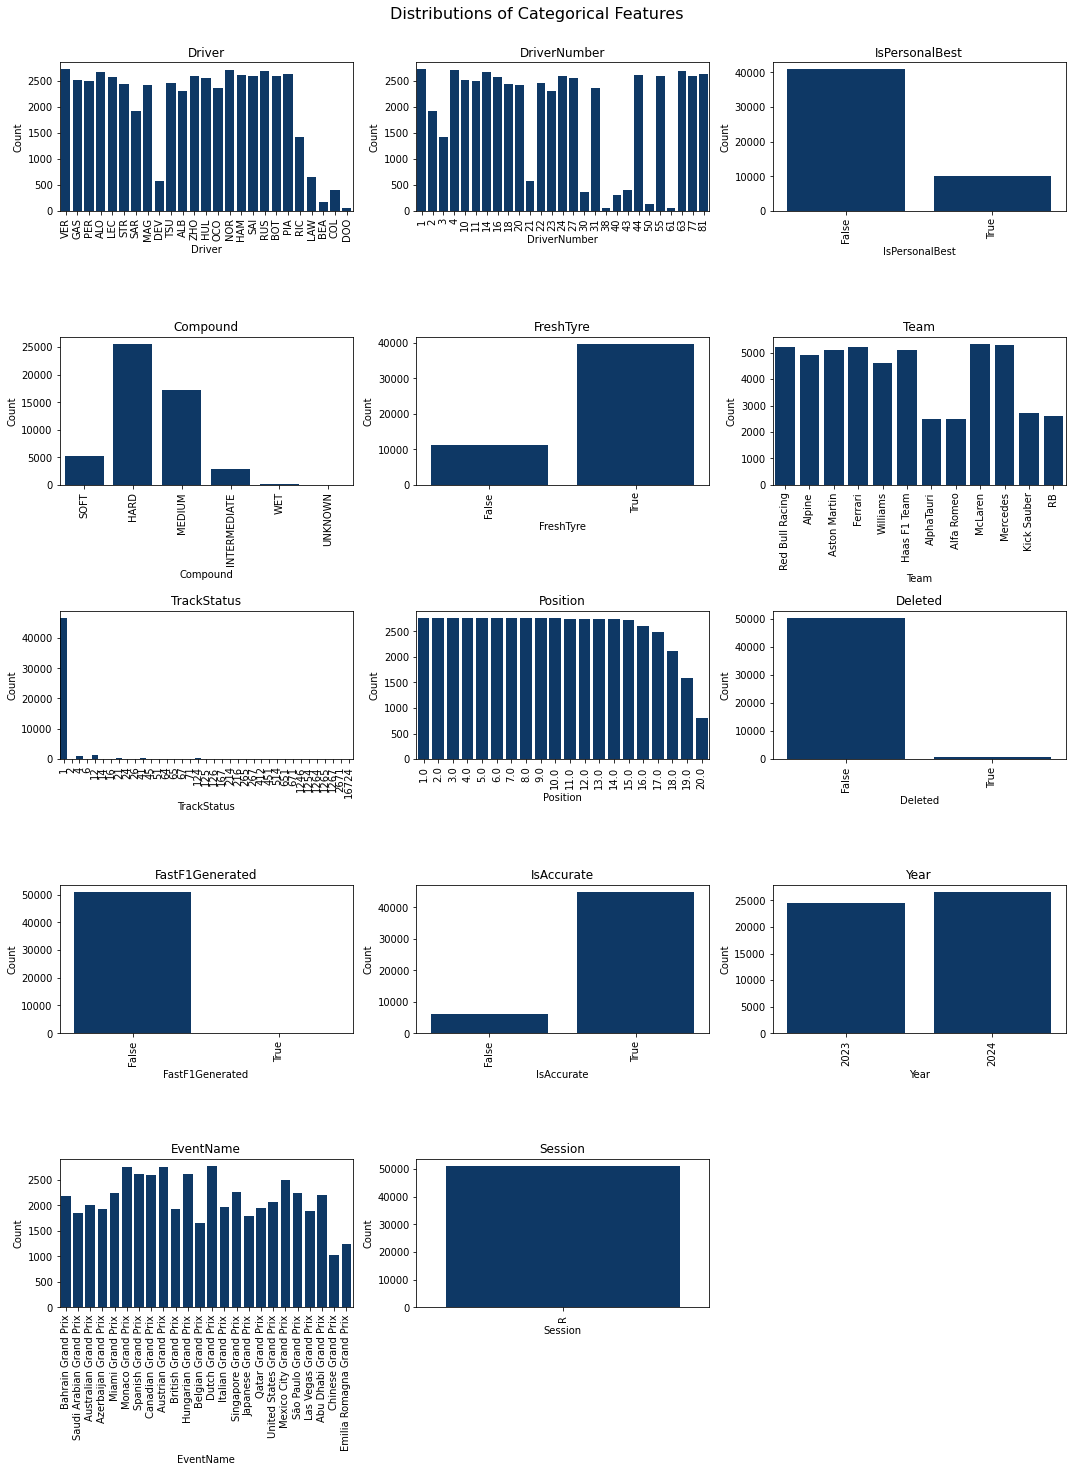

In [0]:
# Plot for categorical features
n_cols = 3
n_rows = int(np.ceil(len(LAP_CATEGORICAL) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col_ in enumerate(LAP_CATEGORICAL):
    sns.countplot(
        data=lap_pd[lap_pd[col_].notna()],
        x=col_,
        ax=axes[i],
        color=BLUE
    )
    axes[i].set_title(col_)
    axes[i].set_xlabel(col_)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Categorical Features", fontsize=16, y=1.02)
plt.show()

#### 2.1.2. Boxplots

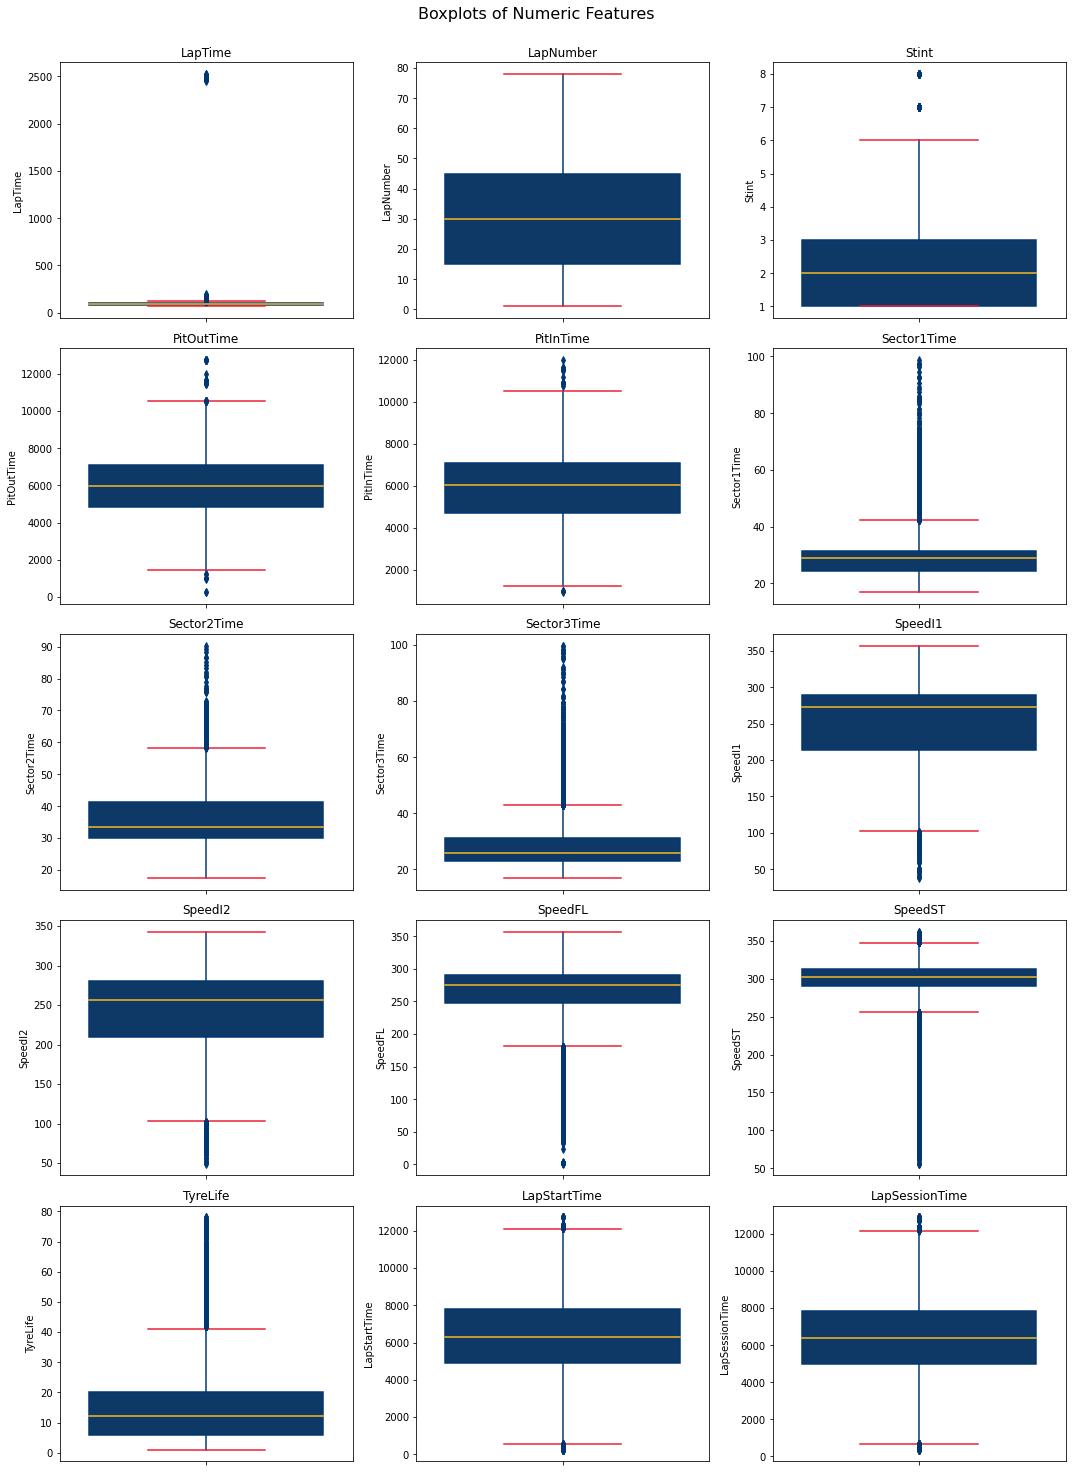

In [0]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(LAP_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, col_ in enumerate(LAP_METRIC):
    sns.boxplot(y=lap_pd[col_], ax=axes[i], color=BLUE, boxprops=dict(edgecolor=BLUE),
        whiskerprops=dict(color=BLUE),
        capprops=dict(color=RED),
        medianprops=dict(color=YELLOW),
        flierprops=dict(markerfacecolor=BLUE, markeredgecolor=BLUE))
    axes[i].set_title(col_)
    axes[i].set_ylabel(col_)
    axes[i].set_xlabel("")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots of Numeric Features", fontsize=16, y=1.02)
plt.show()

#### 2.1.3. Other Plots

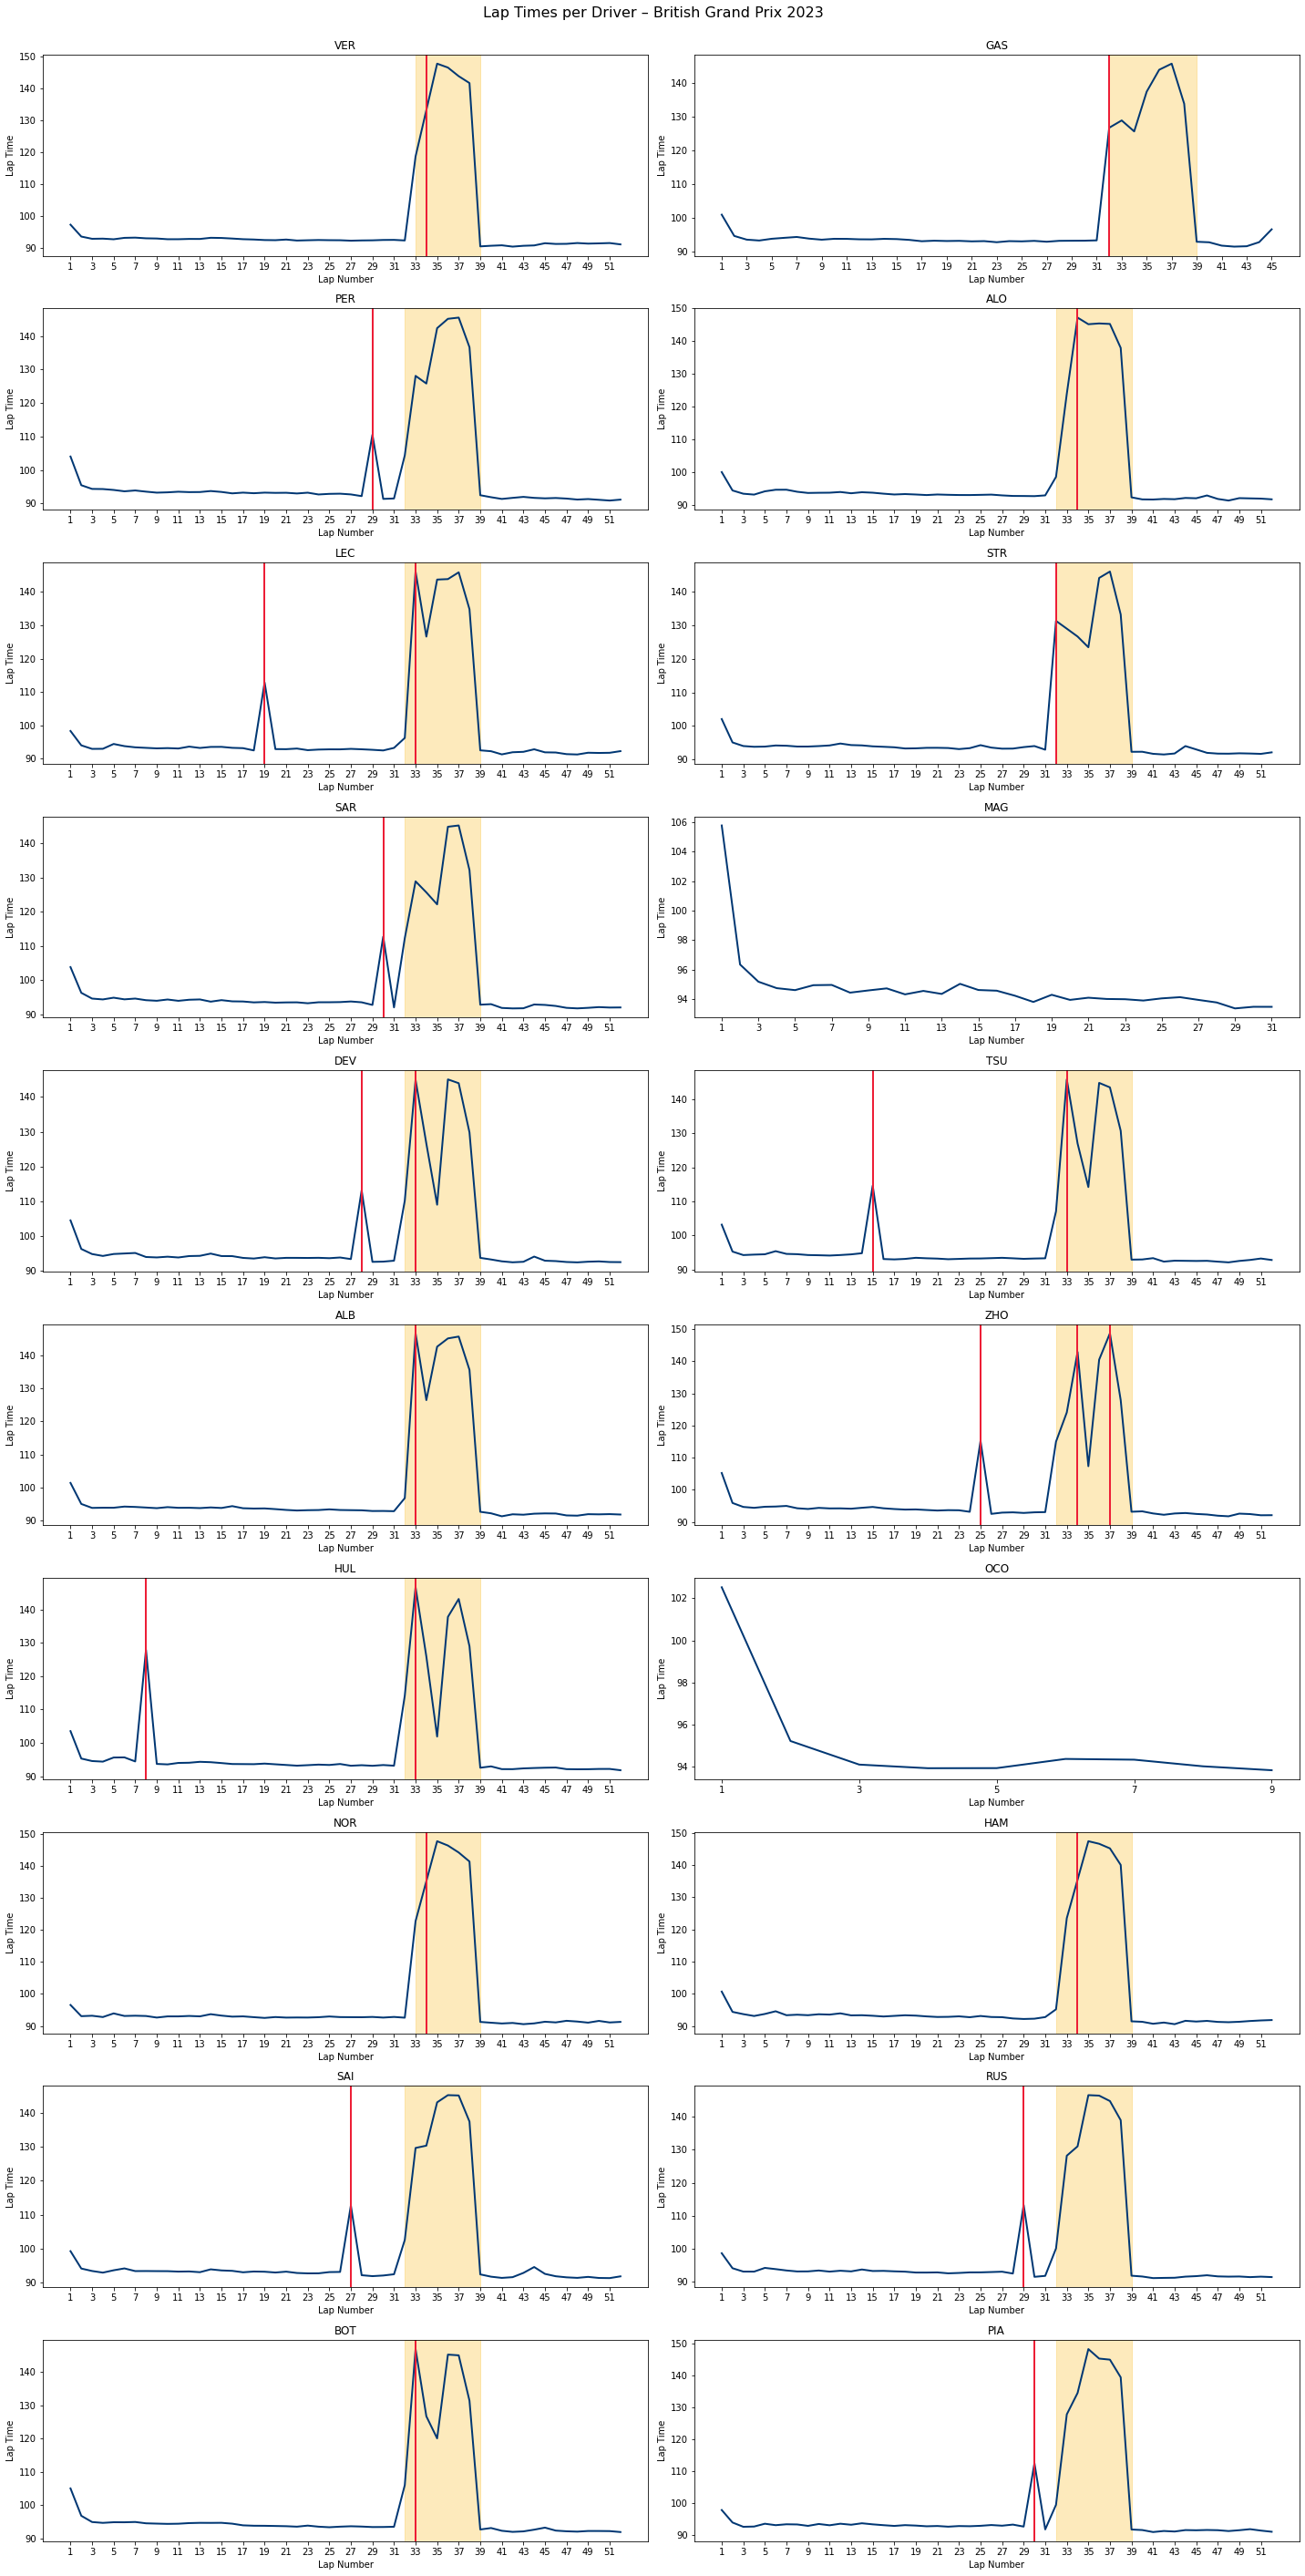

In [0]:
# Filter data
race_df = lap_pd[
    (lap_pd['EventName'] == EVENT_PLT) & 
    (lap_pd['Year'] == YEAR_PLT)
].copy()

n_cols = 2
n_rows = math.ceil(len(race_df['Driver'].unique()) / n_cols)

# Set up subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=False)
axes = axes.flatten()

for i, driver in enumerate(race_df['Driver'].unique()):
    ax = axes[i]
    driver_laps = race_df[race_df['Driver'] == driver].sort_values('LapNumber')

    # Plot lap time
    sns.lineplot(
        data=driver_laps
        ,x='LapNumber'
        ,y='LapTime'
        ,color=BLUE
        ,linewidth=2
        ,ax=ax
    )

    # Add vertical lines for pit stop
    pit_laps = driver_laps[driver_laps['PitOutTime'].notnull()]['LapNumber'].unique()
    for lap in pit_laps:
        ax.axvline(x=lap, color=RED, linestyle='-', linewidth=2)

    # Shade laps with track status different than Green Flag
    non_green_laps = driver_laps[driver_laps['TrackStatus'] != 1]['LapNumber'].values
    if len(non_green_laps) > 0:
        start = non_green_laps[0]
        for j in range(1, len(non_green_laps)):
            if non_green_laps[j] != non_green_laps[j-1] + 1:
                ax.axvspan(start, non_green_laps[j-1] + 1, color=YELLOW, alpha=0.3)
                start = non_green_laps[j]
        ax.axvspan(start, non_green_laps[-1] + 1, color=YELLOW, alpha=0.3)

    ax.set_title(f"{driver}")
    ax.set_xlabel("Lap Number")
    ax.set_ylabel("Lap Time")
    ax.set_xticks(range(driver_laps['LapNumber'].min(), driver_laps['LapNumber'].max() + 1, 2))


# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add suptitle
fig.suptitle(f"Lap Times per Driver – {EVENT_PLT} {YEAR_PLT}", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

This plot shows the majority of drivers pit when there is a track status change. All drivers racing during the 3rd moment of track status change but two decided to pit.

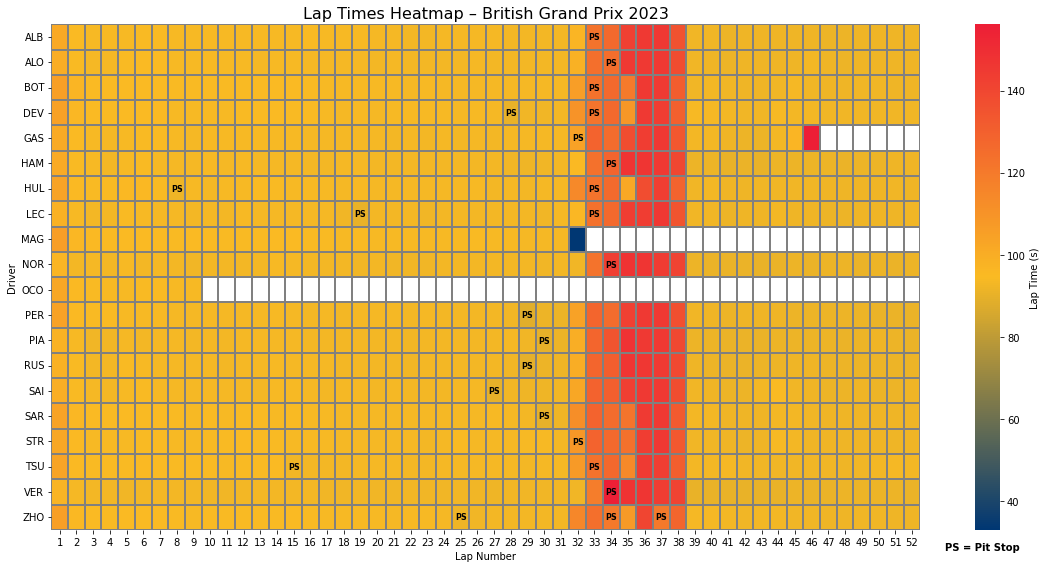

In [0]:
race_df['AdjustedLapTime'] = np.where(
    race_df['PitOutTime'].notna()
    ,race_df['LapSessionTime'] - race_df['LapStartTime'] - (race_df['PitOutTime'] - race_df['LapStartTime'])
    ,race_df['LapSessionTime'] - race_df['LapStartTime']
)

# Pivot the data
heatmap_data = race_df.pivot_table(
    index='Driver',
    columns='LapNumber',
    values='AdjustedLapTime'
)

# Create dataframe for annotations
annotations = pd.DataFrame(
    ''
    ,index=heatmap_data.index
    ,columns=heatmap_data.columns
)
# Filter laps with pit stop
pitstops = race_df[
    (race_df['PitOutTime'].notnull())
]

# Set 'PS' on pit stop laps
for _, row in pitstops.iterrows():
    driver = row['Driver']
    lap = row['LapNumber']
    if driver in annotations.index and lap in annotations.columns:
        annotations.at[driver, lap] = 'PS'

# Create the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data
    ,cmap=CMAP
    ,linewidths=0.2
    ,linecolor='gray'
    ,cbar_kws={'label': 'Lap Time (s)'}
    ,annot=annotations
    ,fmt=''
    ,annot_kws={
        "size": 8
        ,"weight": "bold"
        ,"color": "black"
    }
)

plt.text(
    x=heatmap_data.shape[1] + 1.5
    ,y=heatmap_data.shape[0] + 0.8
    ,s="PS = Pit Stop"
    ,fontsize=10
    ,fontweight='bold'
)

plt.title(f'Lap Times Heatmap – {EVENT_PLT} {YEAR_PLT}', fontsize=16)
plt.xlabel('Lap Number')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

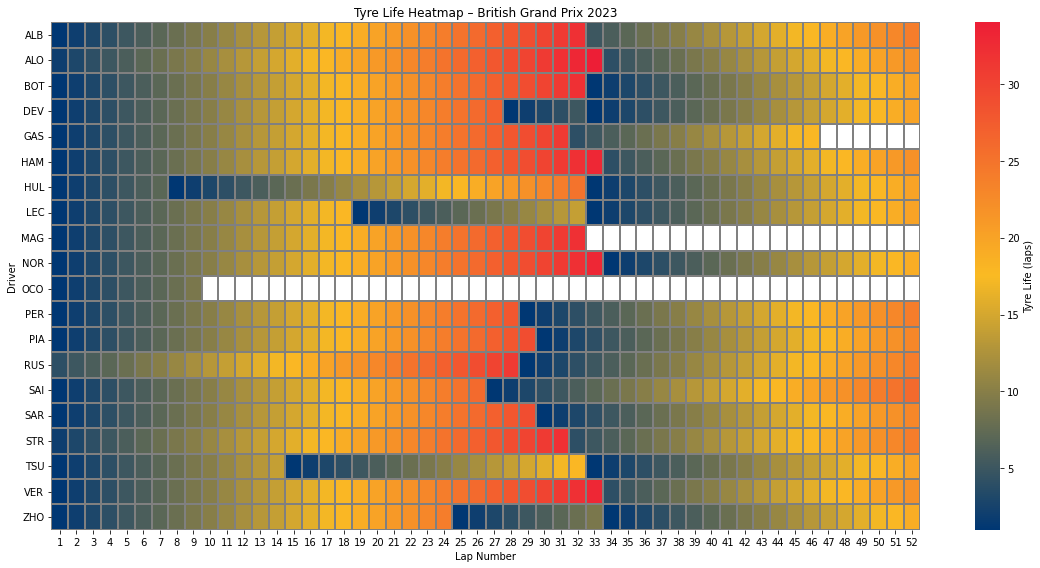

In [0]:
# Pivot the data
heatmap_data = race_df.pivot_table(
    index='Driver',
    columns='LapNumber',
    values='TyreLife'
)

# Create the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    cmap=CMAP,
    linewidths=0.2,
    linecolor='gray',
    cbar_kws={'label': 'Tyre Life (laps)'}
)

plt.title(f'Tyre Life Heatmap – {EVENT_PLT} {YEAR_PLT}')
plt.xlabel('Lap Number')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

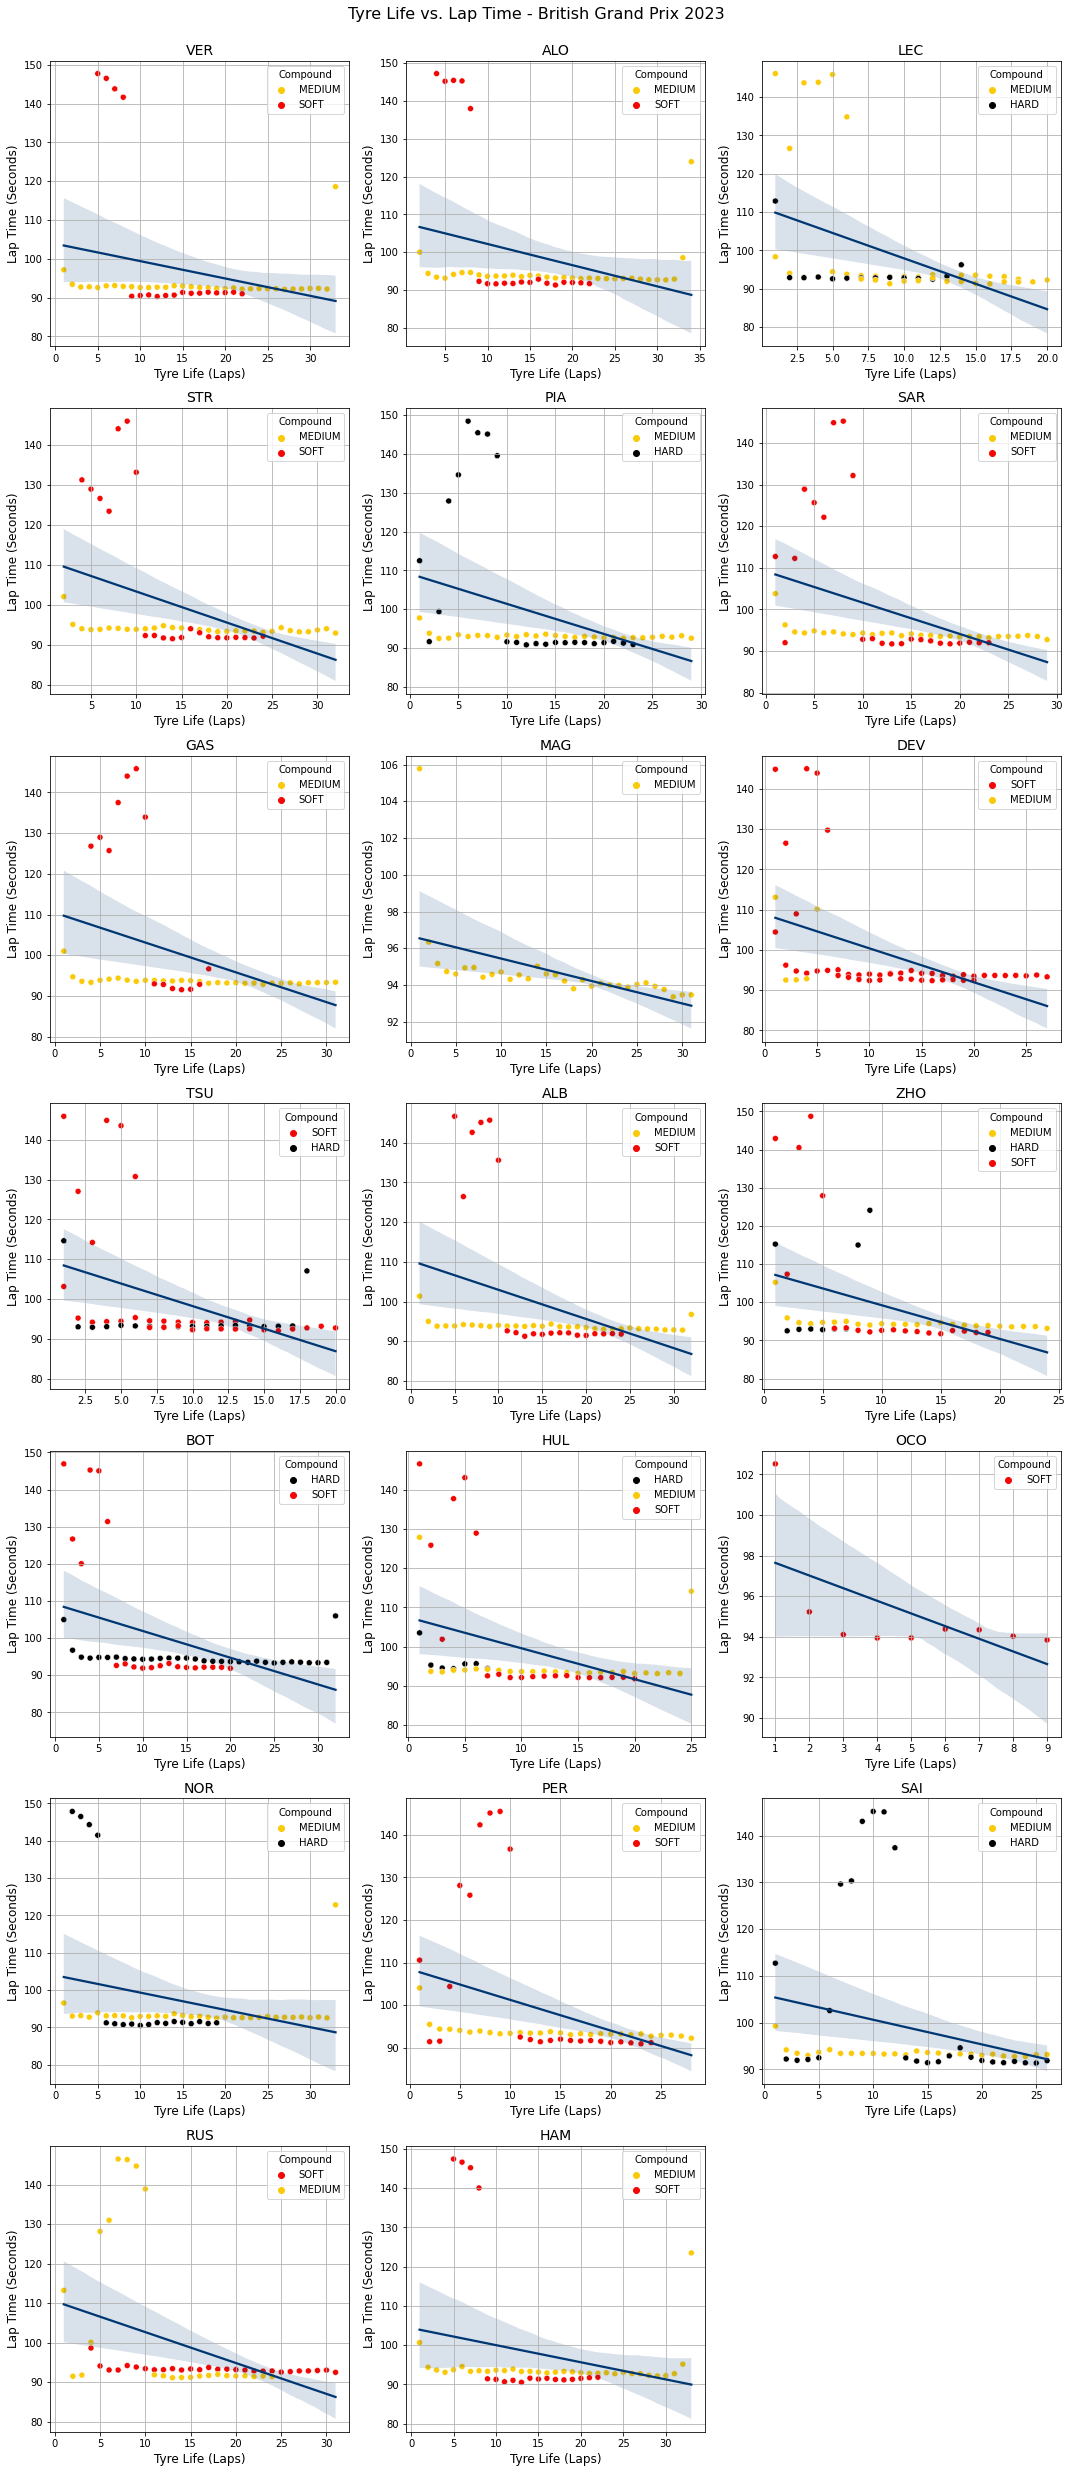

In [0]:
# Filter the data
tyre_life = race_df[(race_df['LapTime'].notna())].sort_values(by='LapNumber')

# Determine the number of rows needed
n_cols = 3
n_rows = (len(tyre_life['Driver'].unique()) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each driver and plot
for i, driver in enumerate(tyre_life['Driver'].unique()):
    # Filter data for the current driver
    driver_data = tyre_life[tyre_life['Driver'] == driver]

    # Create scatter plot for the driver with hue
    sns.scatterplot(
        x='TyreLife', y='LapTime',
        data=driver_data,
        hue='Compound',
        palette=COMPOUND_COLORS,
        ax=axes[i]
    )

    # Add a regression line (single trend, not per compound)
    sns.regplot(
        x='TyreLife', y='LapTime',
        data=driver_data,
        scatter=False,
        color=BLUE,
        ax=axes[i],
        line_kws={'label': 'Trend Line'}
    )

    # Set title and labels for each subplot
    axes[i].set_title(f'{driver}', fontsize=14)
    axes[i].set_xlabel('Tyre Life (Laps)', fontsize=12)
    axes[i].set_ylabel('Lap Time (Seconds)', fontsize=12)
    axes[i].grid(True)

    # Combine legends from both plots (scatter + regplot)
    handles, labels = axes[i].get_legend_handles_labels()
    # Remove duplicates and preserve order
    seen = set()
    new_handles, new_labels = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            new_handles.append(h)
            new_labels.append(l)
            seen.add(l)
    axes[i].legend(new_handles, new_labels, title='Compound')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"Tyre Life vs. Lap Time - {EVENT_PLT} {YEAR_PLT}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

By analysing this plot, it is possible to conclude the first couple of laps on a new set of tyres are usually very slow compared to the remaining.

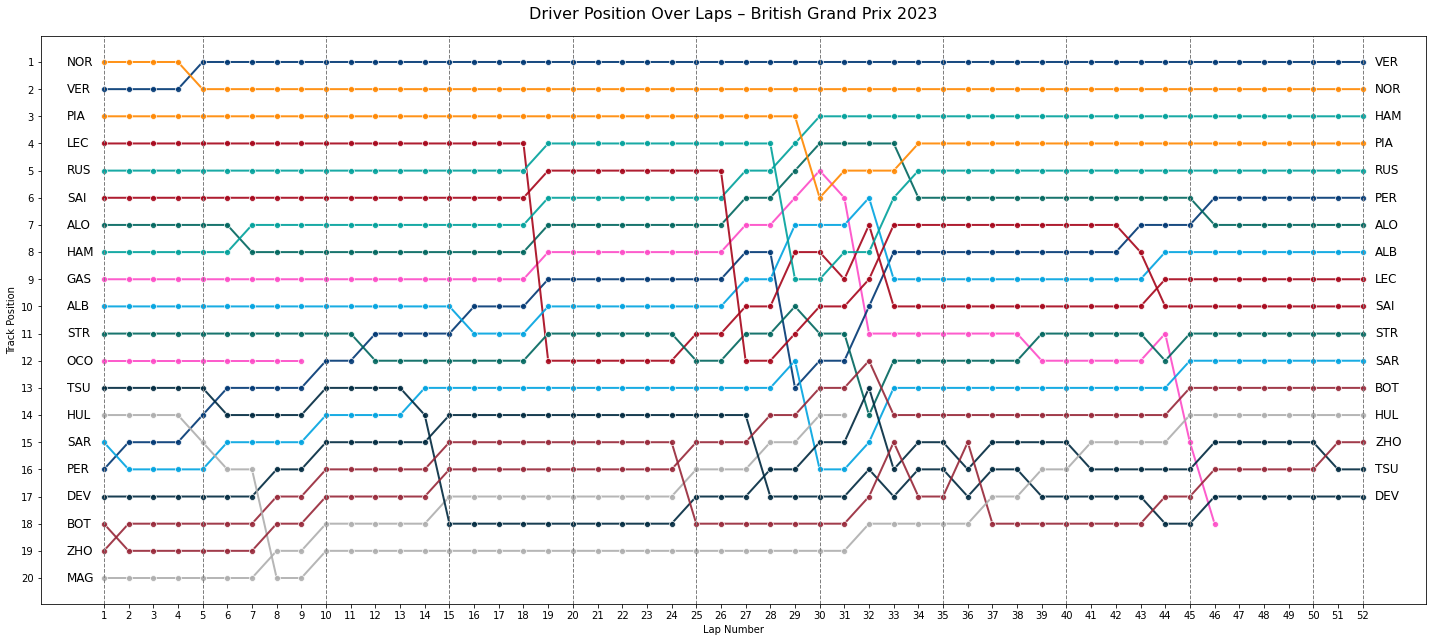

In [0]:
# Create a dictionary that maps each driver to their team color
driver_team_colors = race_df.dropna(subset=['Team']).drop_duplicates(subset=['Driver'])
driver_team_colors['Color'] = driver_team_colors['Team'].map(TEAM_COLORS)

# Create a dictionary for driver names and their corresponding team color
driver_color_map = driver_team_colors.set_index('Driver')['Color'].to_dict()

# Plot the data with team colors
plt.figure(figsize=(20, 9))

# Lineplot of Position vs LapNumber, colored by Driver's team color
sns.lineplot(
    data=race_df
    ,x='LapNumber'
    ,y='Position'
    ,hue='Driver'
    ,palette=driver_color_map  # Use the dictionary with Driver:Color mapping
    ,marker='o'
    ,linewidth=2
    ,alpha=0.9
    ,legend=False
)

# Loop over each driver for labels
for driver in race_df['Driver'].unique():
    driver_data = race_df[race_df['Driver'] == driver]

    # End of the line
    last_lap = driver_data['LapNumber'].max()
    last_pos = driver_data.loc[driver_data['LapNumber'] == last_lap, 'Position'].values[0]
    if last_lap == race_df['LapNumber'].max():
        plt.text(
            x=last_lap + 0.5
            ,y=last_pos
            ,s=driver
            ,fontsize=12
            ,va='center'
        )

    # Start of the line
    first_lap = driver_data['LapNumber'].min()
    first_pos = driver_data.loc[driver_data['LapNumber'] == first_lap, 'Position'].values[0]
    plt.text(
        x=first_lap - 1.5
        ,y=first_pos
        ,s=driver
        ,fontsize=12
        ,va='center'
    )

# Invert y-axis: Position 1 should be at the top
plt.gca().invert_yaxis()

# Set y-axis ticks to be each integer value (positions 1 to max)
plt.yticks(range(1, int(race_df['Position'].max()) + 1))

# Set x-axis to start at 1 and mark each unit
plt.xticks(range(1, int(race_df['LapNumber'].max()) + 1))

# Add vertical dashed lines every 5 units on the x-axis
for lap in range(1, int(race_df['LapNumber'].max()) + 1):
    if lap == 1 or lap % 5 == 0 or lap == int(race_df['LapNumber'].max()):
        plt.axvline(x=lap, color='gray', linestyle='--', linewidth=1)

plt.title(f'Driver Position Over Laps – {EVENT_PLT} {YEAR_PLT}', fontsize=16, y=1.02)
plt.xlabel('Lap Number')
plt.ylabel('Track Position')

plt.tight_layout()
plt.show()

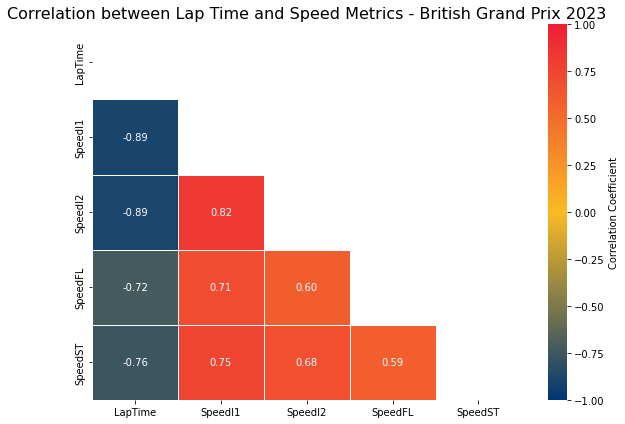

In [0]:
# Calculate correlation matrix between LapTime and speed-related features
speed_corr = race_df[['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(speed_corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    speed_corr
    ,annot=True
    ,cmap=CMAP
    ,vmin=-1
    ,vmax=1
    ,fmt=".2f"
    ,linewidths=0.5
    ,cbar_kws={"label": "Correlation Coefficient"}
    ,mask=mask
)
plt.title(f"Correlation between Lap Time and Speed Metrics - {EVENT_PLT} {YEAR_PLT}", fontsize=16)
plt.tight_layout()
plt.show()

### 2.2. Telemetry Data

In [0]:
# Filter the data, since the dataset is too large and convert to pandas for visualization purposes
telemetry_pd = (
    telemetry_data
    .filter(
        (col("EventName") == EVENT_PLT) &
        (col("Year") == YEAR_PLT)
    )
    .toPandas()
)

#### 2.2.1. Histograms

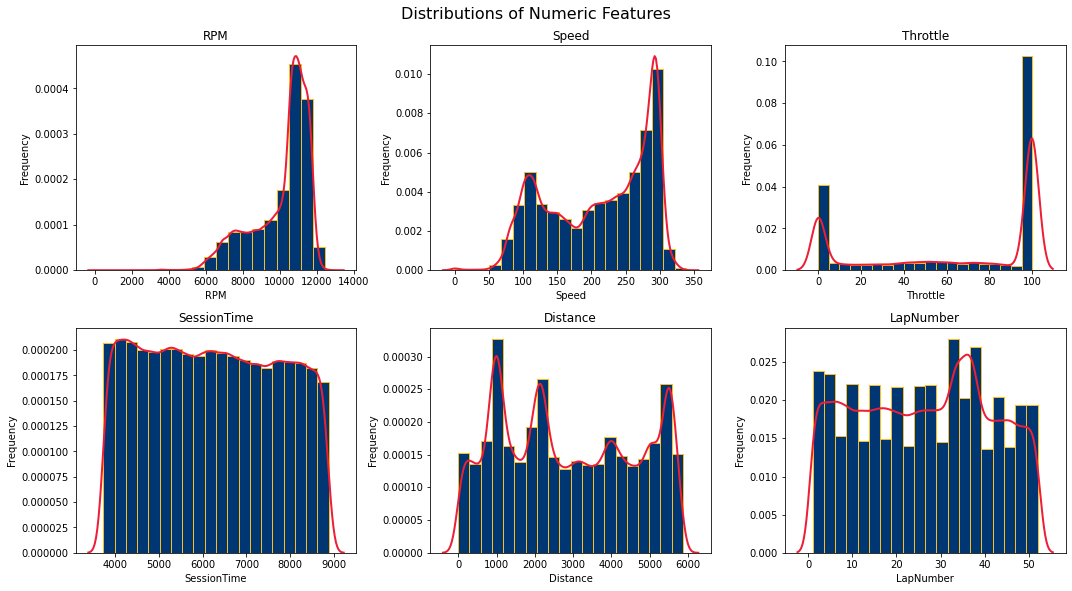

In [0]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(TELEMETRY_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot histogram and density line
for i, col_ in enumerate(TELEMETRY_METRIC):
    sns.histplot(
        data=telemetry_pd
        ,x=col_
        ,ax=axes[i]
        ,bins=sturges_bins(telemetry_pd, col_)
        ,color=BLUE
        ,edgecolor=YELLOW
        ,stat='density'
        ,alpha=1
    )

    sns.kdeplot(
        data=telemetry_pd
        ,x=col_
        ,ax=axes[i]
        ,color=RED
        ,linewidth=2
    )
    
    axes[i].set_title(col_)
    axes[i].set_xlabel(col_)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Numeric Features", fontsize=16, y=1.02)
plt.show()

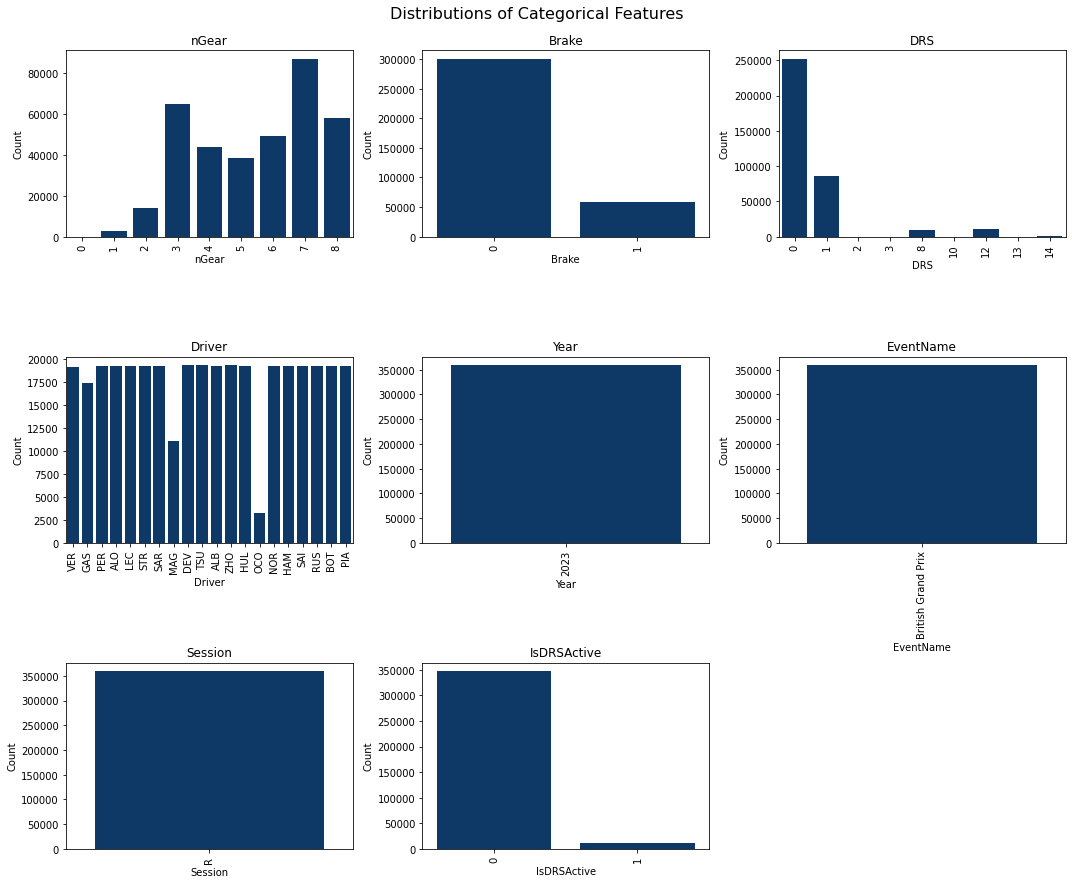

In [0]:
# Plot for categorical features
n_cols_cat = 3
n_rows_cat = int(np.ceil(len(TELEMETRY_CATEGORICAL) / n_cols_cat))
fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(15, n_rows_cat * 4))
axes_cat = axes_cat.flatten()

for i, col_ in enumerate(TELEMETRY_CATEGORICAL):
    sns.countplot(
        data=telemetry_pd[telemetry_pd[col_].notna()],
        x=col_,
        ax=axes_cat[i],
        color=BLUE
    )
    axes_cat[i].set_title(col_)
    axes_cat[i].set_xlabel(col_)
    axes_cat[i].set_ylabel("Count")
    axes_cat[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes_cat)):
    axes_cat[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Categorical Features", fontsize=16, y=1.02)
plt.show()

#### 2.2.2. Boxplots

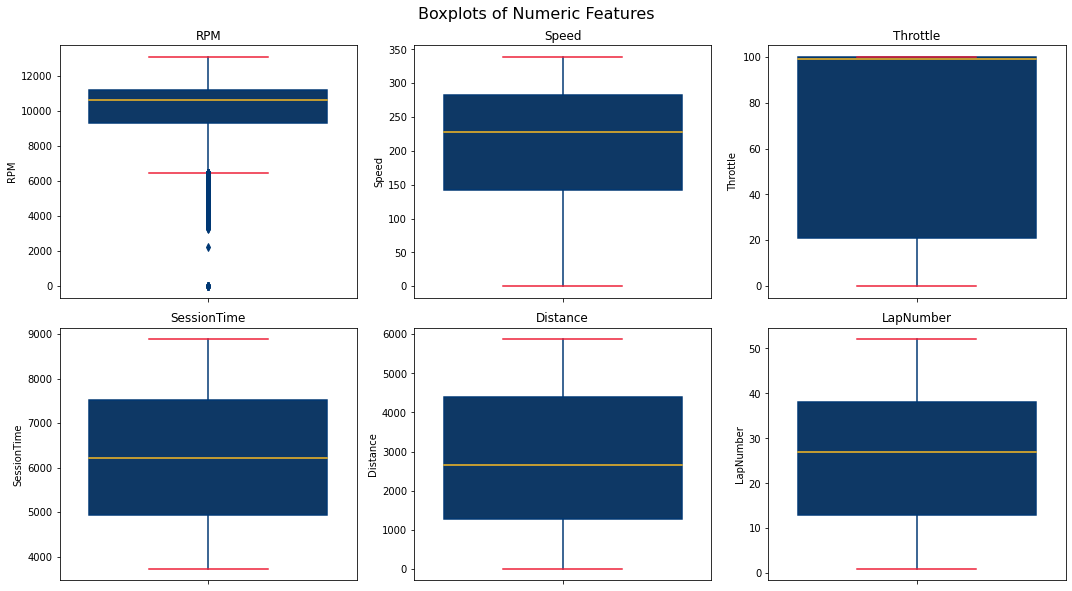

In [0]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(TELEMETRY_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, col_ in enumerate(TELEMETRY_METRIC):
    sns.boxplot(y=telemetry_pd[col_], ax=axes[i], color=BLUE, boxprops=dict(edgecolor=BLUE),
        whiskerprops=dict(color=BLUE),
        capprops=dict(color=RED),
        medianprops=dict(color=YELLOW),
        flierprops=dict(markerfacecolor=BLUE, markeredgecolor=BLUE))
    axes[i].set_title(col_)
    axes[i].set_ylabel(col_)
    axes[i].set_xlabel("")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots of Numeric Features", fontsize=16, y=1.02)
plt.show()

#### 2.2.3. Other Plots

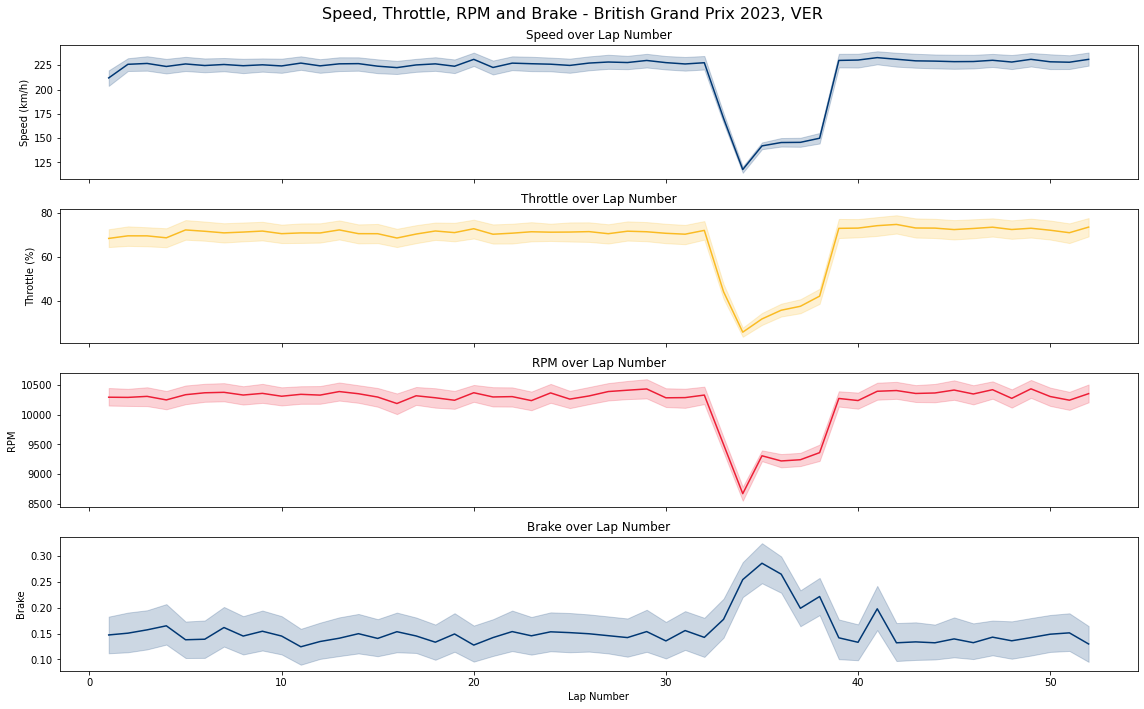

In [0]:
df_plot = telemetry_pd[(telemetry_pd['Driver'] == DRIVER_PLT)]

# Create a figure with multiple subplots
fig, axs = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

# Plot Speed
sns.lineplot(data=df_plot, x="LapNumber", y="Speed", ax=axs[0], color=BLUE)
axs[0].set_title(f"Speed over Lap Number")
axs[0].set_ylabel("Speed (km/h)")

# Plot Throttle
sns.lineplot(data=df_plot, x="LapNumber", y="Throttle", ax=axs[1], color=YELLOW)
axs[1].set_title("Throttle over Lap Number")
axs[1].set_ylabel("Throttle (%)")

# Plot RPM
sns.lineplot(data=df_plot, x="LapNumber", y="RPM", ax=axs[2], color=RED)
axs[2].set_title("RPM over Lap Number")
axs[2].set_ylabel("RPM")
axs[2].set_xlabel("Lap Number")

# Plot Brake
sns.lineplot(data=df_plot, x="LapNumber", y="Brake", ax=axs[3], color=BLUE)
axs[3].set_title("Brake over Lap Number")
axs[3].set_ylabel("Brake")
axs[3].set_xlabel("Lap Number")

plt.suptitle(f"Speed, Throttle, RPM and Brake - {EVENT_PLT} {YEAR_PLT}, {DRIVER_PLT}", fontsize=16)

plt.tight_layout()
plt.show()

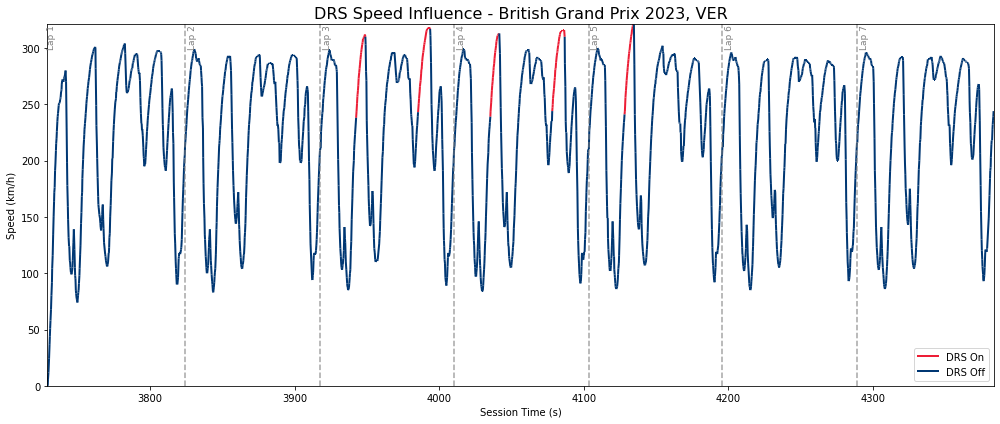

In [0]:
# Filter data
drs_plot = df_plot[(df_plot['LapNumber'] >= 1) & (df_plot['LapNumber'] <= 7)]

# First, identify where LapNumber changes (lap start points)
lap_changes = drs_plot[['SessionTime', 'LapNumber']].drop_duplicates('LapNumber')

# Prepare segments for LineCollection
x = drs_plot['SessionTime'].values
y = drs_plot['Speed'].values
c = drs_plot['IsDRSActive'].astype(int).values

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Split into DRS On and Off segments
segments_on = [seg for i, seg in enumerate(segments) if c[i] == 1]
segments_off = [seg for i, seg in enumerate(segments) if c[i] == 0]

# Create separate LineCollections
lc_on = LineCollection(segments_on, colors=RED, linewidth=2, label='DRS On')
lc_off = LineCollection(segments_off, colors=BLUE, linewidth=2, label='DRS Off')

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
ax.add_collection(lc_on)
ax.add_collection(lc_off)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(f"DRS Speed Influence - {EVENT_PLT} {YEAR_PLT}, {DRIVER_PLT}", fontsize=16)
ax.set_xlabel("Session Time (s)")
ax.set_ylabel("Speed (km/h)")

# Add vertical lines for each lap change
for _, row in lap_changes.iterrows():
    ax.axvline(x=row['SessionTime'] - 2, color='grey', linestyle='--', alpha=0.7)
    ax.text(row['SessionTime'], y.max(), f"Lap {int(row['LapNumber'])}", 
            rotation=90, verticalalignment='top', horizontalalignment='left', fontsize=9, color='grey')

# Add manual legend
legend_elements = [
    Line2D([0], [0], color=RED, lw=2, label='DRS On'),
    Line2D([0], [0], color=BLUE, lw=2, label='DRS Off')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

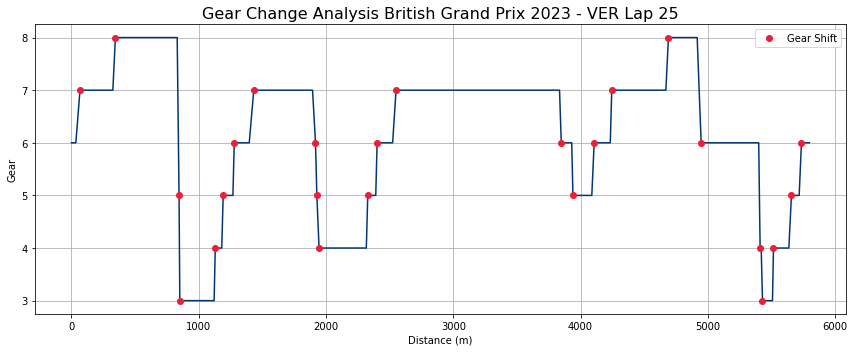

In [0]:
# Select one example lap
gear_df = df_plot[df_plot['LapNumber'] == 25].sort_values('Distance')

# Identify gear shifts
gear_diff = gear_df['nGear'].diff().fillna(0)
gear_shift_indices = gear_diff != 0

# Plotting
plt.figure(figsize=(12, 5))

# Plot the gear line
plt.plot(gear_df['Distance'], gear_df['nGear'], linestyle='-', color=BLUE)

# Overlay markers only at gear shift points
plt.plot(
    gear_df['Distance'][gear_shift_indices]
    ,gear_df['nGear'][gear_shift_indices]
    ,marker='o'
    ,linestyle='None'
    ,color=RED
    ,label='Gear Shift'
)

# Styling
plt.title(f'Gear Change Analysis {EVENT_PLT} {YEAR_PLT} - {DRIVER_PLT} Lap 25', fontsize=16)
plt.xlabel('Distance (m)')
plt.ylabel('Gear')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


### 2.3. Weather Data

In [0]:
# Filter the data, since the dataset is too large and convert to pandas for visualization purposes
weather_pd = (
    weather_data
    .filter(
        (col("EventName") == EVENT_PLT) &
        (col("Year") == YEAR_PLT)
    )
    .toPandas()
)

#### 2.3.1. Histograms

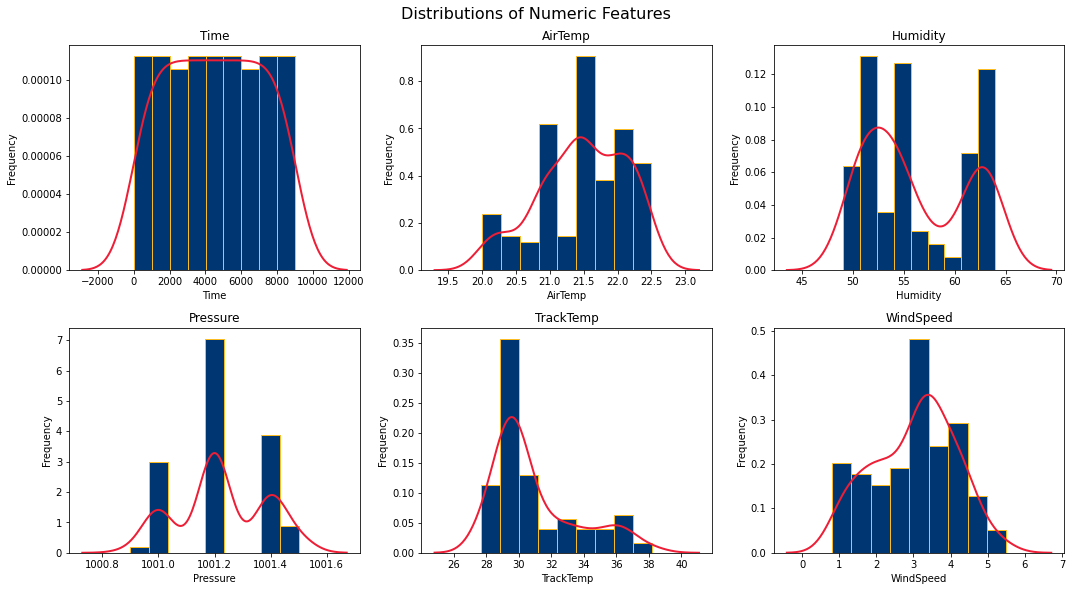

In [0]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(WEATHER_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot histogram and density line
for i, col_ in enumerate(WEATHER_METRIC):
    sns.histplot(
        data=weather_pd
        ,x=col_
        ,ax=axes[i]
        ,bins=sturges_bins(weather_pd, col_)
        ,color=BLUE
        ,edgecolor=YELLOW
        ,stat='density'
        ,alpha=1
    )

    sns.kdeplot(
        data=weather_pd
        ,x=col_
        ,ax=axes[i]
        ,color=RED
        ,linewidth=2
    )
    
    axes[i].set_title(col_)
    axes[i].set_xlabel(col_)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Numeric Features", fontsize=16, y=1.02)
plt.show()

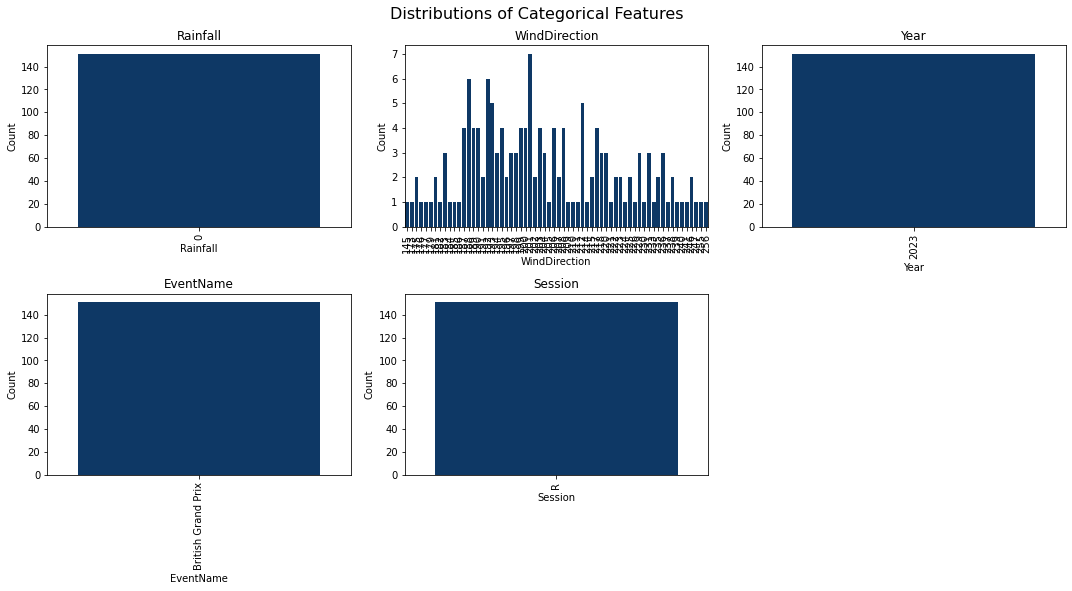

In [0]:
# Plot for categorical features
n_cols_cat = 3
n_rows_cat = int(np.ceil(len(WEATHER_CATEGORICAL) / n_cols_cat))
fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(15, n_rows_cat * 4))
axes_cat = axes_cat.flatten()

for i, col_ in enumerate(WEATHER_CATEGORICAL):
    sns.countplot(
        data=weather_pd[weather_pd[col_].notna()],
        x=col_,
        ax=axes_cat[i],
        color=BLUE
    )
    axes_cat[i].set_title(col_)
    axes_cat[i].set_xlabel(col_)
    axes_cat[i].set_ylabel("Count")
    axes_cat[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes_cat)):
    axes_cat[j].axis('off')

plt.tight_layout()
plt.suptitle("Distributions of Categorical Features", fontsize=16, y=1.02)
plt.show()

#### 2.2.2. Boxplots

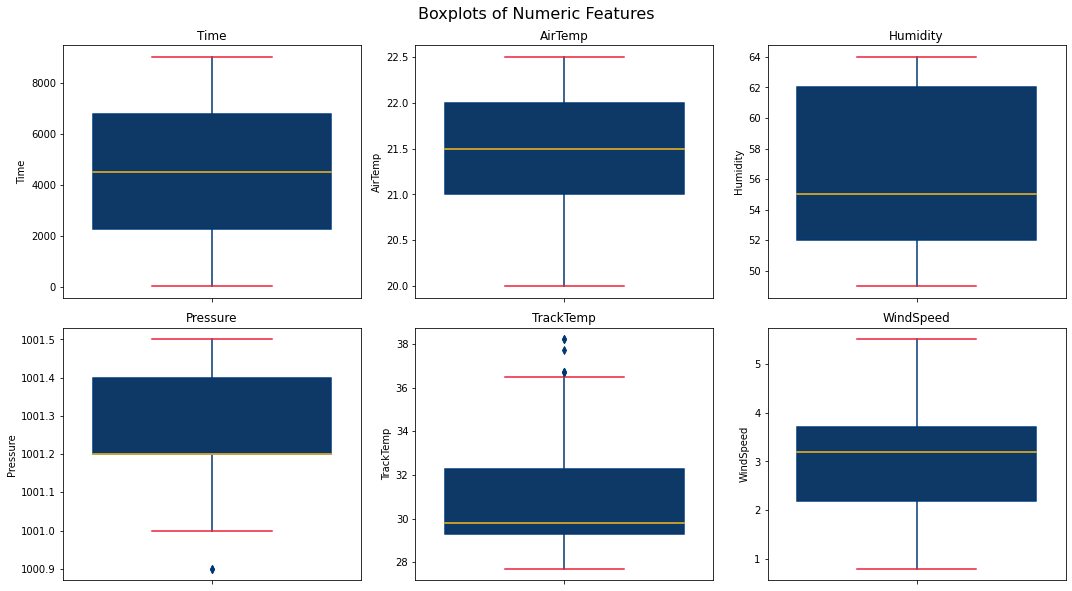

In [0]:
# Subplot layout
n_cols = 3
n_rows = int(np.ceil(len(WEATHER_METRIC) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, col_ in enumerate(WEATHER_METRIC):
    sns.boxplot(y=weather_pd[col_], ax=axes[i], color=BLUE, boxprops=dict(edgecolor=BLUE),
        whiskerprops=dict(color=BLUE),
        capprops=dict(color=RED),
        medianprops=dict(color=YELLOW),
        flierprops=dict(markerfacecolor=BLUE, markeredgecolor=BLUE))
    axes[i].set_title(col_)
    axes[i].set_ylabel(col_)
    axes[i].set_xlabel("")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots of Numeric Features", fontsize=16, y=1.02)
plt.show()

#### 2.2.3. Other Plots

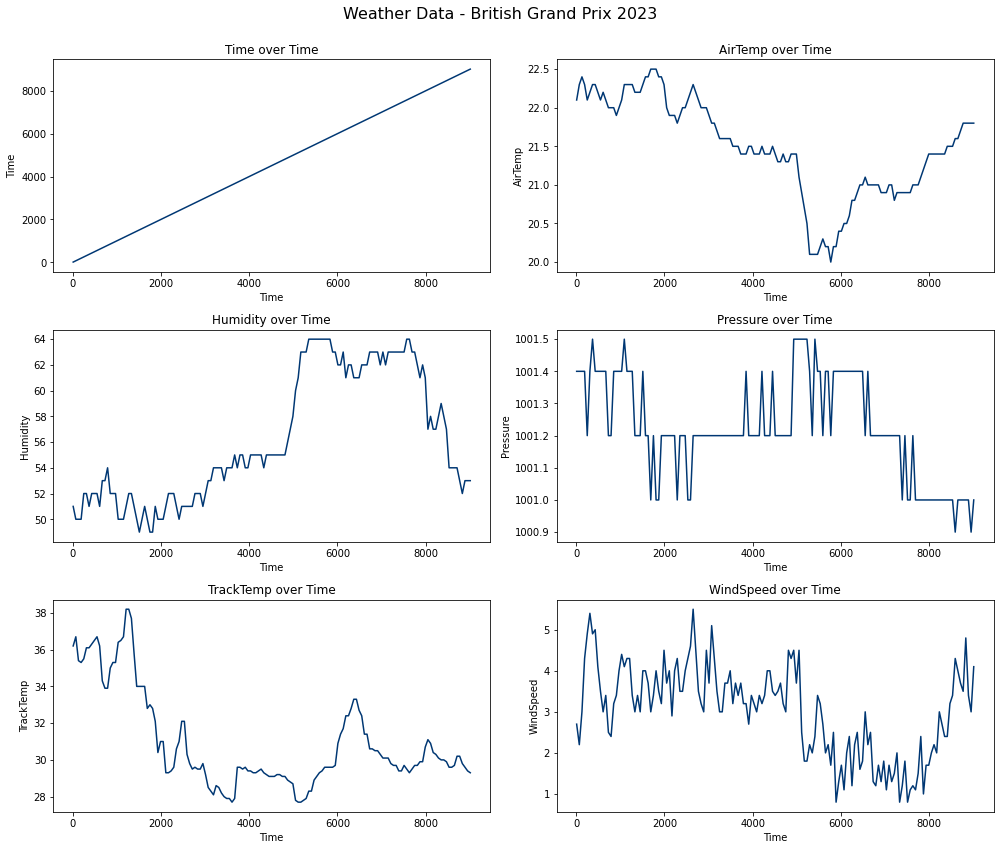

In [0]:
# Set up plot grid
n_metrics = len(WEATHER_METRIC)
n_cols = 2
n_rows = math.ceil(n_metrics / n_cols)

plt.figure(figsize=(14, 4 * n_rows))

for i, metric in enumerate(WEATHER_METRIC, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.lineplot(data=weather_pd, x='Time', y=metric, color=BLUE)
    plt.title(f'{metric} over Time')
    plt.xlabel('Time')
    plt.ylabel(metric)

plt.suptitle(f"Weather Data - {EVENT_PLT} {YEAR_PLT}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

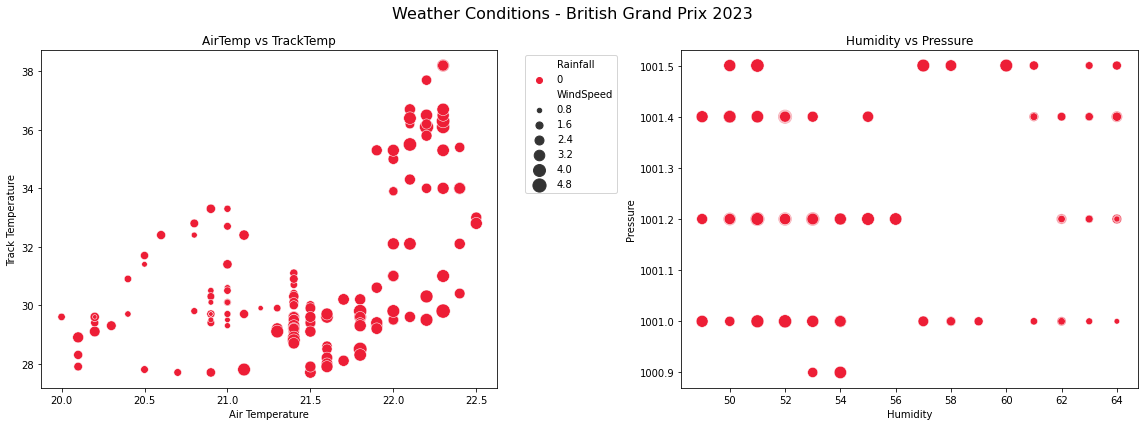

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# AirTemp vs TrackTemp
sns.scatterplot(
    data=weather_pd
    ,x='AirTemp'
    ,y='TrackTemp'
    ,hue='Rainfall'
    ,size='WindSpeed'
    ,palette={
        True: BLUE
        ,False: RED
    }
    ,sizes=(20, 200)
    ,ax=axes[0]
)
axes[0].set_title('AirTemp vs TrackTemp')
axes[0].set_xlabel('Air Temperature')
axes[0].set_ylabel('Track Temperature')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Humidity vs Pressure
sns.scatterplot(
    data=weather_pd
    ,x='Humidity'
    ,y='Pressure'
    ,hue='Rainfall'
    ,size='WindSpeed'
    ,palette={
        True: BLUE
        ,False: RED
    }
    ,sizes=(20, 200)
    ,ax=axes[1]
)
axes[1].set_title('Humidity vs Pressure')
axes[1].set_xlabel('Humidity')
axes[1].set_ylabel('Pressure')

axes[1].legend_.remove()

plt.suptitle(f"Weather Conditions - {EVENT_PLT} {YEAR_PLT}", fontsize=16)
plt.tight_layout()
plt.show()

## 3. Data Processing

In this section, inconsistencies and missing values are handled.

### 3.1. Inconsistencies

In [0]:
# Checking laps with no time information
display(
    lap_data
    .filter((
        col("Sector1Time").isNull() & 
        col("Sector2Time").isNull() & 
        col("Sector3Time").isNull()
    ))
    .limit(5)
)

Driver DriverNumber LapTime LapNumber Stint PitOutTime PitInTime Sector1Time Sector2Time Sector3Time SpeedI1 SpeedI2 SpeedFL SpeedST IsPersonalBest Compound TyreLife FreshTyre Team LapStartTime TrackStatus Position Deleted FastF1Generated IsAccurate Year EventName Session LapSessionTime LEC 16 null 40 3 null null null null null null null null null null HARD 7 true Ferrari 7643.001 1 null false true false 2023 Bahrain Grand Prix R 7738.974 STR 18 null 17 2 null null null null null null null null null null HARD 5 false Aston Martin 5327.98 12 null false true false 2023 Saudi Arabian Grand Prix R 5377.473 GAS 10 null 57 3 null null null null null null null null null null SOFT 3 false Alpine 10740.74 12 null false true false 2023 Australian Grand Prix R 10764.751 LEC 16 null 1 1 null null null null null null null null null false MEDIUM 1 true Ferrari 3736.863 124 null false true false 2023 Australian Grand Prix R 3834.954 SAR 2 null 57 7 null null null null null null null null null null SOFT 3 false Williams 10743.049 12 null false true false 2023 Australian Grand Prix R 10764.751

In [0]:
# Flagging drivers who DNF on the following lap
window_spec = Window.partitionBy("Year", "EventName", "Session", "Driver").orderBy("LapNumber")

lap_data = lap_data.withColumn(
    'DNF',
    when(
        lag(
            when(
                (col("Sector1Time").isNull() & 
                 col("Sector2Time").isNull() & 
                 col("Sector3Time").isNull()),
                1
            ).otherwise(0),
            -1
        ).over(window_spec) == 1,
        1
    ).otherwise(0)
)

In [0]:
# Removing them rows
lap_data = (
    lap_data
    .filter(~(
        col("Sector1Time").isNull() & 
        col("Sector2Time").isNull() & 
        col("Sector3Time").isNull()
    ))
)

### 3.2. Missing Values

#### 3.2.1. Lap Data

In [0]:
# Compute null counts
null_counts = lap_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in lap_data.columns])

# Convert to a Row to filter in Python
null_counts_dict = null_counts.first().asDict()

# Filter and print only columns with nulls
for col_name, count in null_counts_dict.items():
    if count > 0:
        print(f"{col_name}: {count}")

LapTime: 595
PitOutTime: 49189
PitInTime: 49167
Sector1Time: 1006
Sector2Time: 4
Sector3Time: 91
SpeedI1: 7852
SpeedI2: 26
SpeedFL: 1795
SpeedST: 4265


**Lap Time**

In [0]:
# Check missing values
lap_data.filter(col("LapTime").isNull()).count()

Out[58]: 595

In [0]:
# Fix missing values - compute by subtracting the time at the end and at the start of the lap
lap_data = lap_data.withColumn("LapTime", col("LapSessionTime") - col("LapStartTime"))

In [0]:
# Recheck
lap_data.filter(col("LapTime").isNull()).count()

Out[60]: 0

**PitOutTime**, **PitInTime** - Does not make sense to fill in these missing values; these features will be used for feature engineering.

**Sector1Time**, **Sector2Time**, **Sector3Time** - These features will be used for feature engineering, no need to fill them.

**SpeedI1**, **SpeedI2**, **SpeedFL**, **SpeedST**

In [0]:
# Check missing values
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

Out[61]: 12665

In [0]:
# Fill missing values - speed rolling average
driver_lap_window = (
    Window
    .partitionBy("Year", "EventName", "Session", "Driver")
    .orderBy("LapNumber")
    .rowsBetween(Window.unboundedPreceding, -1)
)

# List of columns to process
speed_cols = ["SpeedI1", "SpeedI2", "SpeedFL", "SpeedST"]

# Fill missing values
for col_name in speed_cols:
    cumulative_avg = avg(col(col_name)).over(driver_lap_window)
    lap_data = (
        lap_data
        .withColumn(
            col_name,
            when(col(col_name).isNull(), cumulative_avg).otherwise(col(col_name))
        )
    )

In [0]:
# Recheck
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

Out[63]: 113

In [0]:
# Fill missing values - teammate's speed in same lap

# Self-join on teammate info
teammate_join = lap_data.alias("self").join(
    lap_data.alias("tm"),
    on=[
        col("self.Year") == col("tm.Year"),
        col("self.EventName") == col("tm.EventName"),
        col("self.Session") == col("tm.Session"),
        col("self.Team") == col("tm.Team"),
        col("self.LapNumber") == col("tm.LapNumber"),
        col("self.Driver") != col("tm.Driver")
    ],
    how="left"
)

# Replace missing values from teammate values
updated_cols = [
    coalesce(col(f"self.{col_name}"), col(f"tm.{col_name}")).alias(col_name)
    if col_name in speed_cols else col(f"self.{col_name}")
    for col_name in lap_data.columns
]

lap_data = teammate_join.select(*updated_cols)

In [0]:
# Recheck
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

Out[65]: 75

In [0]:
# Fill missing values - finish line speed with longest straight speed
lap_data = (
    lap_data
    .withColumn(
        "SpeedFL",
        when(col("SpeedFL").isNull(), col("SpeedST")).otherwise(col("SpeedFL"))
    )
)

In [0]:
# Recheck
lap_data.filter(
    col("SpeedI1").isNull() |
    col("SpeedI2").isNull() |
    col("SpeedFL").isNull() |
    col("SpeedST").isNull()
).count()

Out[67]: 0

#### 3.2.2. Telemetry Data

In [0]:
# Compute null counts
null_counts = telemetry_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in telemetry_data.columns])

# Convert to a Row to filter in Python
null_counts_dict = null_counts.first().asDict()

# Filter and print only columns with nulls
for col_name, count in null_counts_dict.items():
    if count > 0:
        print(f"{col_name}: {count}")

No missing values :)

#### 3.2.3. Weather Data

In [0]:
# Compute null counts
null_counts = weather_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in weather_data.columns])

# Convert to a Row to filter in Python
null_counts_dict = null_counts.first().asDict()

# Filter and print only columns with nulls
for col_name, count in null_counts_dict.items():
    if count > 0:
        print(f"{col_name}: {count}")

No missing values :)

## 4. Data Engineering

### 4.1. Lap Data

In [0]:
# Define windows
start_position_window = Window.partitionBy("Year", "EventName", "Session", "Driver")
lap_order_window = start_position_window.orderBy("LapNumber")

In [0]:
# Creating new features
lap_data = (
    lap_data
    .withColumn("rolling_avg_laptime", avg("LapTime").over(lap_order_window.rowsBetween(Window.unboundedPreceding, 0)))
    .withColumn("pit_in_lap", when(col("PitInTime").isNotNull(), 1).otherwise(0))
    .withColumn("pit_exit_lap", when(col("PitOutTime").isNotNull(), 1).otherwise(0))
    .withColumn(
        "last_pit_lap",
        coalesce(
            max("pit_exit_lap").over(lap_order_window.rowsBetween(Window.unboundedPreceding, 0)),
            lit(0)
        )
    )
    .withColumn("laps_since_last_pit", col("LapNumber") - col("last_pit_lap"))
    .withColumn(
        "prev_compound", 
        when(
            col("LapNumber") == 1, col("Compound")
        ).otherwise(
            lag("Compound").over(lap_order_window)
        )
    )
    .withColumn(
        "pit_stop_duration",
        when(
            (col("PitOutTime").isNull()) | ((col("PitOutTime").isNotNull()) & (col("LapNumber") == 1)),
            lit(0)
        ).otherwise(
            col("PitOutTime") - lag("PitInTime").over(lap_order_window)
        )
    )
    .withColumn("max_pit_stop_duration", max("pit_stop_duration").over(lap_order_window))
    .withColumn("start_position", first(when(col("LapNumber") == 1, col("Position")), ignorenulls=True).over(start_position_window))
    .withColumn("position_change_since_race_start", col("start_position") - col("Position"))
    .withColumn(
        "fastest_sector", when(
            (col("Sector1Time") <= col("Sector2Time")) & (col("Sector1Time") <= col("Sector3Time")), 1
        ).when(
            (col("Sector2Time") <= col("Sector1Time")) & (col("Sector2Time") <= col("Sector3Time")), 2
        ).otherwise(3)
    )
)

In [0]:
lap_data = lap_data.drop(
    "Sector1Time", "Sector2Time", "Sector3Time", "PitOutTime"
)

In [0]:
display(lap_data.limit(1))

Driver DriverNumber LapTime LapNumber Stint PitInTime SpeedI1 SpeedI2 SpeedFL SpeedST IsPersonalBest Compound TyreLife FreshTyre Team LapStartTime TrackStatus Position Deleted FastF1Generated IsAccurate Year EventName Session LapSessionTime DNF rolling_avg_laptime pit_in_lap pit_exit_lap last_pit_lap laps_since_last_pit prev_compound pit_stop_duration max_pit_stop_duration start_position position_change_since_race_start fastest_sector HUL 27 99.54700000000003 1 1 null 280.0 291.0 209.0 288.0 false MEDIUM 1 true Haas F1 Team 3744.519 1 13 false false false 2023 Abu Dhabi Grand Prix R 3844.066 0 99.54700000000003 0 0 0 1 MEDIUM 0.0 0.0 13 0 3

### 4.2. Telemetry Data

In [0]:
# Define window
window_spec = Window.partitionBy("Year", "EventName", "Driver", "LapNumber").orderBy("SessionTime")
last_50_window = window_spec.rowsBetween(-49, 0)

In [0]:
# Compute per-lap aggregates
telemetry_data = (
    telemetry_data
    .withColumn("avg_speed_last_lap", avg("Speed").over(window_spec))
    .withColumn("max_speed_last_lap", max("Speed").over(window_spec))
    .withColumn("avg_throttle_last_lap", avg("Throttle").over(window_spec))
    .withColumn("avg_brake_last_lap", avg("Brake").over(window_spec))
    .withColumn("avg_rpm", avg("RPM").over(window_spec))
    .withColumn("gear_change", when(col("nGear") != lag("nGear").over(window_spec), 1).otherwise(0))
    .withColumn("gear_change_count", sum("gear_change").over(window_spec))
    .withColumn(
        "DRS_activation_count",
        sum(
            when(
                (~lag("DRS").over(window_spec).isin(10, 12, 14)) & (col("DRS").isin(10, 12, 14)),
                1
            ).otherwise(0)
        ).over(window_spec.rowsBetween(Window.unboundedPreceding, 0))
    )
    .withColumn("rolling_throttle_mean", avg("Throttle").over(last_50_window))
    .withColumn("rolling_brake_intensity", avg("Brake").over(last_50_window))
    .withColumn("rolling_gear_change", when(col("nGear") != lag("nGear").over(window_spec), 1).otherwise(0))
    .withColumn("rolling_gear_change_rate", avg("rolling_gear_change").over(last_50_window))
    .withColumn("rolling_speed_mean", avg("Speed").over(last_50_window))
)

In [0]:
# Final sector features (define final 5% of distance per lap)
max_distance = telemetry_data.groupBy("Year", "EventName", "Driver", "LapNumber").agg(max("Distance").alias("max_dist"))
telemetry_data = telemetry_data.join(max_distance, on=["Year", "EventName", "Driver", "LapNumber"])
telemetry_data = telemetry_data.withColumn("in_final_sector", col("Distance") >= col("max_dist") * 0.95)

# Define new window
final_sector_window = Window.partitionBy("Year", "EventName", "Driver", "LapNumber").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

telemetry_data = (
    telemetry_data
    .withColumn("final_sector_avg_speed", avg(when(col("in_final_sector"), col("Speed"))).over(final_sector_window))
    .withColumn("final_sector_throttle", avg(when(col("in_final_sector"), col("Throttle"))).over(final_sector_window))
    .withColumn("final_sector_brake", avg(when(col("in_final_sector"), col("Brake"))).over(final_sector_window))
)

In [0]:
display(telemetry_data.limit(1))

Year EventName Driver LapNumber RPM Speed nGear Throttle Brake DRS SessionTime Distance Session IsDRSActive avg_speed_last_lap max_speed_last_lap avg_throttle_last_lap avg_brake_last_lap avg_rpm gear_change gear_change_count DRS_activation_count rolling_throttle_mean rolling_brake_intensity rolling_gear_change rolling_gear_change_rate rolling_speed_mean max_dist in_final_sector final_sector_avg_speed final_sector_throttle final_sector_brake 2023 Abu Dhabi Grand Prix ALB 12 10721 221 6 100 0 0 4764.005 10.4975 R 0 221.0 221 100.0 0.0 10721.0 0 0 0 100.0 0.0 0 0.0 221.0 5208.631666666669 false 153.47826086956522 46.869565217391305 0.34782608695652173

In [0]:
# Select final per-lap features
lap_feature_cols = [
    "EventName", "Driver", "LapNumber", "Year", "Session",
    "avg_speed_last_lap", "max_speed_last_lap",
    "avg_throttle_last_lap", "avg_brake_last_lap",
    "gear_change_count", "avg_rpm", "DRS_activation_count",
    "rolling_throttle_mean", "rolling_brake_intensity",
    "rolling_gear_change_rate", "rolling_speed_mean",
    "final_sector_avg_speed", "final_sector_throttle", 
    "final_sector_brake"
]

# For all columns, take the FIRST value per (Driver, LapNumber)
# Because window functions already populated each row with the same value within each lap
aggregated_laps = (
    telemetry_data
    .select(*lap_feature_cols)
    .groupBy("Year", "EventName", "Session", "Driver", "LapNumber")
    .agg(*[
        first(col_name).alias(col_name) 
        if col_name != "DRS_activation_count" 
        else last(col_name).alias(col_name) 
        for col_name in lap_feature_cols 
        if col_name not in ("Year", "EventName", "Session", "Driver", "LapNumber")
    ])
)

In [0]:
display(aggregated_laps.limit(3))

Year EventName Session Driver LapNumber avg_speed_last_lap max_speed_last_lap avg_throttle_last_lap avg_brake_last_lap gear_change_count avg_rpm DRS_activation_count rolling_throttle_mean rolling_brake_intensity rolling_gear_change_rate rolling_speed_mean final_sector_avg_speed final_sector_throttle final_sector_brake 2023 Abu Dhabi Grand Prix R ALB 12 221.0 221 100.0 0.0 0 10721.0 0 100.0 0.0 0.0 221.0 153.47826086956522 46.869565217391305 0.34782608695652173 2023 Abu Dhabi Grand Prix R ALB 41 225.0 225 100.0 0.0 0 10646.0 0 100.0 0.0 0.0 225.0 157.95833333333334 47.791666666666664 0.3333333333333333 2023 Abu Dhabi Grand Prix R ALB 47 229.0 229 100.0 0.0 0 11006.0 0 100.0 0.0 0.0 229.0 160.5 43.0 0.2916666666666667

### 4.3. Weather Data

In [0]:
# Join weather and lap data on session keys
joined = weather_data.alias("w").join(
    lap_data.select(
        "LapNumber", "LapStartTime", "LapSessionTime", "Year", "EventName", "Session"
    ).alias("l"),
    on=[
        col("w.Year") == col("l.Year"),
        col("w.EventName") == col("l.EventName"),
        col("w.Session") == col("l.Session")
    ],
    how="left"
)

# Filter to keep only rows where weather Time is inside lap range
filtered = joined.filter(
    (col("w.Time") >= col("l.LapStartTime")) &
    (col("w.Time") <= col("l.LapSessionTime"))
)

# Step 3: Select columns and reattach to full weather_data
weather_data = filtered.select(
    col("w.*"), 
    col("l.LapNumber")
)

In [0]:
display(weather_data.limit(3))

Time AirTemp Humidity Pressure Rainfall TrackTemp WindDirection WindSpeed Year EventName Session LapNumber 3825.76 27.3 22.0 1016.7 0 31.2 190 0.6 2023 Bahrain Grand Prix R 1 3765.73 27.3 22.0 1016.7 0 31.2 226 0.5 2023 Bahrain Grand Prix R 1 3945.758 27.3 22.0 1016.9 0 31.1 197 0.6 2023 Bahrain Grand Prix R 2

In [0]:
# Compute per-lap aggregates
weather_data = (
    weather_data
    .groupBy("Year", "EventName", "Session", "LapNumber")
    .agg(
        avg("AirTemp").alias("avg_air_temp"),
        avg("Humidity").alias("avg_humidity"),
        avg("Pressure").alias("avg_pressure"),
        max("Rainfall").alias("max_rainfall"),
        avg("TrackTemp").alias("avg_track_temp"),
        avg("WindDirection").alias("avg_wind_direction"),
        avg("WindSpeed").alias("avg_wind_speed")
    )
)

In [0]:
display(weather_data.limit(3))

Year EventName Session LapNumber avg_air_temp avg_humidity avg_pressure max_rainfall avg_track_temp avg_wind_direction avg_wind_speed 2023 Canadian Grand Prix R 3 18.5 63.0 1011.5 0 32.5 304.0 2.0 2023 Hungarian Grand Prix R 67 29.327586206896544 32.275862068965516 987.9724137931034 0 45.77586206896552 173.10344827586206 1.1758620689655166 2023 Bahrain Grand Prix R 57 26.300000000000008 21.0 1017.3999999999997 0 28.699999999999992 170.47058823529412 0.4588235294117646

### Joining the Data

In [0]:
# Join lap_data and telemetry_data
data = (
    lap_data.alias('lap')
    .join(
        aggregated_laps.alias('telemetry'),
        on=["Year", "EventName", "Session", "Driver", "LapNumber"],
        how="inner"
    )
    .join(
        weather_data.alias('weather'),  # <- use the aggregated weather data
        on=["Year", "EventName", "Session", "LapNumber"],
        how="inner"
    )
)

In [0]:
# Create target variable
data = (
    data
    .withColumn(
        "WillPitNextLap", when(
            lead("PitInTime", 1).over(Window.partitionBy("Year", "EventName", "Session", "Driver").orderBy("LapNumber")).isNotNull(), 1
        )
    .otherwise(0)
    .cast(IntegerType())
    )
)

data = data.drop("PitInTime")

In [0]:
display(data.limit(3))

Year EventName Session LapNumber Driver DriverNumber LapTime Stint SpeedI1 SpeedI2 SpeedFL SpeedST IsPersonalBest Compound TyreLife FreshTyre Team LapStartTime TrackStatus Position Deleted FastF1Generated IsAccurate LapSessionTime DNF rolling_avg_laptime pit_in_lap pit_exit_lap last_pit_lap laps_since_last_pit prev_compound pit_stop_duration max_pit_stop_duration start_position position_change_since_race_start fastest_sector avg_speed_last_lap max_speed_last_lap avg_throttle_last_lap avg_brake_last_lap gear_change_count avg_rpm DRS_activation_count rolling_throttle_mean rolling_brake_intensity rolling_gear_change_rate rolling_speed_mean final_sector_avg_speed final_sector_throttle final_sector_brake avg_air_temp avg_humidity avg_pressure max_rainfall avg_track_temp avg_wind_direction avg_wind_speed WillPitNextLap 2023 Abu Dhabi Grand Prix R 1 HUL 27 99.54700000000003 1 280.0 291.0 209.0 288.0 false MEDIUM 1 true Haas F1 Team 3744.519 1 13 false false false 3844.066 0 99.54700000000003 0 0 0 1 MEDIUM 0.0 0.0 13 0 3 0.0 0 20.0 0.0 0 10384.0 0 20.0 0.0 0.0 0.0 152.4814814814815 48.48148148148148 0.2222222222222222 27.090909090909097 49.0 1014.7000000000003 0 33.60000000000001 337.54545454545456 2.036363636363636 0 2023 Abu Dhabi Grand Prix R 2 HUL 27 92.92100000000028 1 279.0 288.0 209.0 297.0 true MEDIUM 2 true Haas F1 Team 3844.066 1 14 false false true 3936.987 0 96.23400000000015 0 0 0 2 MEDIUM 0.0 0.0 13 -1 1 226.0 226 100.0 0.0 0 12060.0 0 100.0 0.0 0.0 226.0 157.96 46.28 0.28 27.0 50.05263157894737 1014.8052631578951 0 33.49473684210526 313.5263157894737 2.0315789473684207 0 2023 Abu Dhabi Grand Prix R 3 HUL 27 91.35100000000011 1 286.0 297.0 209.0 284.0 true MEDIUM 3 true Haas F1 Team 3936.987 1 14 false false true 4028.338 0 94.60633333333347 0 0 0 3 MEDIUM 0.0 0.0 13 -1 1 223.0 223 100.0 0.0 0 11065.0 2 100.0 0.0 0.0 223.0 151.5 48.35 0.3 27.068965517241384 49.310344827586206 1014.9000000000002 0 33.7 334.37931034482756 1.8551724137931038 0

In [0]:
data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- EventName: string (nullable = true)
 |-- Session: string (nullable = true)
 |-- LapNumber: integer (nullable = true)
 |-- Driver: string (nullable = true)
 |-- DriverNumber: integer (nullable = true)
 |-- LapTime: double (nullable = true)
 |-- Stint: integer (nullable = true)
 |-- SpeedI1: double (nullable = true)
 |-- SpeedI2: double (nullable = true)
 |-- SpeedFL: double (nullable = true)
 |-- SpeedST: double (nullable = true)
 |-- IsPersonalBest: boolean (nullable = true)
 |-- Compound: string (nullable = true)
 |-- TyreLife: integer (nullable = true)
 |-- FreshTyre: boolean (nullable = true)
 |-- Team: string (nullable = true)
 |-- LapStartTime: double (nullable = true)
 |-- TrackStatus: integer (nullable = true)
 |-- Position: integer (nullable = true)
 |-- Deleted: boolean (nullable = true)
 |-- FastF1Generated: boolean (nullable = true)
 |-- IsAccurate: boolean (nullable = true)
 |-- LapSessionTime: double (nullable = true)
 |-- DNF

## Data Modelling

In [0]:
# Define train and test data
train_data = data.filter(
    (col("EventName") == "Abu Dhabi Grand Prix") &
    (col("Year") == 2023) & 
    (col("Driver") == "VER")
)
test_data = data.filter(
    (col("EventName") == "Abu Dhabi Grand Prix") &
    (col("Year") == 2024) & 
    (col("Driver") == "VER")
)

In [0]:
# Check unique values for categorical columns
categorical_cols = ["Team", "Compound", "Driver", "EventName", "prev_compound"]
for cat_col in categorical_cols:
    unique_count = train_data.select(cat_col).distinct().count()
    print(f"Unique values in {cat_col}: {unique_count}")

Unique values in Team: 1
Unique values in Compound: 2
Unique values in Driver: 1
Unique values in EventName: 1
Unique values in prev_compound: 2


In [0]:
# Define preprocessing
indexers_and_encoders = [
    StringIndexer(inputCol="Team", outputCol="TeamIndex", handleInvalid="keep"),
    StringIndexer(inputCol="Compound", outputCol="CompoundIndex", handleInvalid="keep"),
    StringIndexer(inputCol="Driver", outputCol="DriverIndex", handleInvalid="keep"),
    StringIndexer(inputCol="EventName", outputCol="EventNameIndex", handleInvalid="keep"),
    StringIndexer(inputCol="prev_compound", outputCol="prev_compound_index", handleInvalid="keep"),
    OneHotEncoder(inputCol="CompoundIndex", outputCol="CompoundIndex_ohe"),
    OneHotEncoder(inputCol="prev_compound_index", outputCol="prev_compound_ohe"),
    OneHotEncoder(inputCol="DriverIndex", outputCol="DriverIndex_ohe"),
    OneHotEncoder(inputCol="TeamIndex", outputCol="TeamIndex_ohe")
]

In [0]:
# Define the pipeline
pipeline = Pipeline(stages=indexers_and_encoders)

In [0]:
metrics_by_lap = {}

max_lap = train_data.agg({"LapNumber": "max"}).collect()[0][0]

for lap in range(5, max_lap):
    print(f"Training on laps ≤ {lap}, predicting lap {lap + 1}")

    train_subset = train_data.filter(col("LapNumber") <= lap)
    test_subset = train_data.filter(col("LapNumber") == lap + 1)

    model = pipeline.fit(train_subset)

    train_transformed = model.transform(train_subset)
    test_transformed = model.transform(test_subset)

    ohe_columns = ["CompoundIndex_ohe", "prev_compound_ohe", "DriverIndex_ohe", "TeamIndex_ohe"]
    train_transformed = expand_one_hot_vectors(train_transformed, ohe_columns)
    test_transformed = expand_one_hot_vectors(test_transformed, ohe_columns)

    feature_cols = [c for c in train_transformed.columns if
                    c.startswith("CompoundIndex_ohe_") or
                    c.startswith("prev_compound_ohe_") or
                    c.startswith("DriverIndex_ohe_") or
                    c.startswith("TeamIndex_ohe_")]

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    train_assembled = assembler.transform(train_transformed)
    test_assembled = assembler.transform(test_transformed)

    rf = RandomForestClassifier(labelCol="WillPitNextLap", featuresCol="features", maxBins=64)
    rf_model = rf.fit(train_assembled)

    predictions = rf_model.transform(test_assembled)

    # Evaluators that work with single or very few samples
    multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="WillPitNextLap", predictionCol="prediction")

    f1 = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
    precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
    recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})

    # Calculate accuracy manually since it might be just 1 or few rows
    pred_and_label = predictions.select("prediction", "WillPitNextLap").collect()
    accuracy = builtins.sum(1 if row["prediction"] == row["WillPitNextLap"] else 0 for row in pred_and_label) / len(pred_and_label)

    metrics_by_lap[lap + 1] = {
        "Accuracy": accuracy,
        "F1": f1,
        "Precision": precision,
        "Recall": recall
    }

    print(f"Lap {lap + 1} Metrics: Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Unique values in Team: 1
Unique values in Compound: 2
Unique values in Driver: 1
Unique values in EventName: 1
Unique values in prev_compound: 2
Training on laps ≤ 5, predicting lap 6
Lap 6 Metrics: Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000
Training on laps ≤ 6, predicting lap 7
Lap 7 Metrics: Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000
Training on laps ≤ 7, predicting lap 8
Lap 8 Metrics: Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000
Training on laps ≤ 8, predicting lap 9
Lap 9 Metrics: Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000
Training on laps ≤ 9, predicting lap 10
Lap 10 Metrics: Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000
Training on laps ≤ 10, predicting lap 11
Lap 11 Metrics: Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000
Training on laps ≤ 11, predicting lap 12
Lap 12 Metrics: Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000
Training on laps ≤ 12

In [0]:
# Fit the pipeline
model = pipeline.fit(train_data)

# Transform training and test data
train_transformed = model.transform(train_data)
test_transformed = model.transform(test_data)

# Expand one-hot encoded columns
ohe_columns = ["CompoundIndex_ohe", "prev_compound_ohe", "DriverIndex_ohe", "TeamIndex_ohe"]
train_transformed = expand_one_hot_vectors(train_transformed, ohe_columns)
test_transformed = expand_one_hot_vectors(test_transformed, ohe_columns)

# Define feature columns
feature_cols = [c for c in train_transformed.columns if
                c.startswith("CompoundIndex_ohe_") or
                c.startswith("prev_compound_ohe_") or
                c.startswith("DriverIndex_ohe_") or
                c.startswith("TeamIndex_ohe_")]

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_assembled = assembler.transform(train_transformed)
test_assembled = assembler.transform(test_transformed)

# Train Random Forest model
rf = RandomForestClassifier(labelCol="WillPitNextLap", featuresCol="features", maxBins=64)
rf_model = rf.fit(train_assembled)

# Make predictions for 2024 race
predictions = rf_model.transform(test_assembled)

# Evaluate the model with multiclass metrics
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="WillPitNextLap", predictionCol="prediction")
f1 = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})

# Calculate accuracy manually
pred_and_label = predictions.select("prediction", "WillPitNextLap").collect()
accuracy = builtins.sum(1 if row["prediction"] == row["WillPitNextLap"] else 0 for row in pred_and_label) / len(pred_and_label)

# Evaluate AUC-ROC and AUPR (Area Under Precision-Recall) for binary classification
binary_evaluator = BinaryClassificationEvaluator(labelCol="WillPitNextLap", rawPredictionCol="rawPrediction")
auc_roc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
aupr = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderPR"})

# Store and print metrics
metrics = {
    "Accuracy": accuracy,
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
    "AUC-ROC": auc_roc,
    "AUPR": aupr
}

print("Metrics for 2024 Abu Dhabi Grand Prix Prediction:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUPR: {aupr:.4f}")

predictions.select("LapNumber", "WillPitNextLap", "prediction").orderBy("LapNumber").show()

Unique values in Team: 1
Unique values in Compound: 2
Unique values in Driver: 1
Unique values in EventName: 1
Unique values in prev_compound: 2
Metrics for 2024 Abu Dhabi Grand Prix Prediction:
Accuracy: 0.9828
F1: 0.9742
Precision: 0.9658
Recall: 0.9828
AUC-ROC: 0.5000
AUPR: 0.0172
+---------+--------------+----------+
|LapNumber|WillPitNextLap|prediction|
+---------+--------------+----------+
|        1|             0|       0.0|
|        2|             0|       0.0|
|        3|             0|       0.0|
|        4|             0|       0.0|
|        5|             0|       0.0|
|        6|             0|       0.0|
|        7|             0|       0.0|
|        8|             0|       0.0|
|        9|             0|       0.0|
|       10|             0|       0.0|
|       11|             0|       0.0|
|       12|             0|       0.0|
|       13|             0|       0.0|
|       14|             0|       0.0|
|       15|             0|       0.0|
|       16|             0|     

In [0]:
TN = predictions.filter((col("WillPitNextLap") == 0) & (col("prediction") == 0)).count()
FP = predictions.filter((col("WillPitNextLap") == 0) & (col("prediction") == 1)).count()
FN = predictions.filter((col("WillPitNextLap") == 1) & (col("prediction") == 0)).count()
TP = predictions.filter((col("WillPitNextLap") == 1) & (col("prediction") == 1)).count()

# Create confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Convert to pandas DataFrame for better display
confusion_df = pd.DataFrame(
    confusion_matrix,
    index=["Actual Negative (0)", "Actual Positive (1)"],
    columns=["Predicted Negative (0)", "Predicted Positive (1)"]
)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_df)

Confusion Matrix:
                     Predicted Negative (0)  Predicted Positive (1)
Actual Negative (0)                      57                       0
Actual Positive (1)                       1                       0


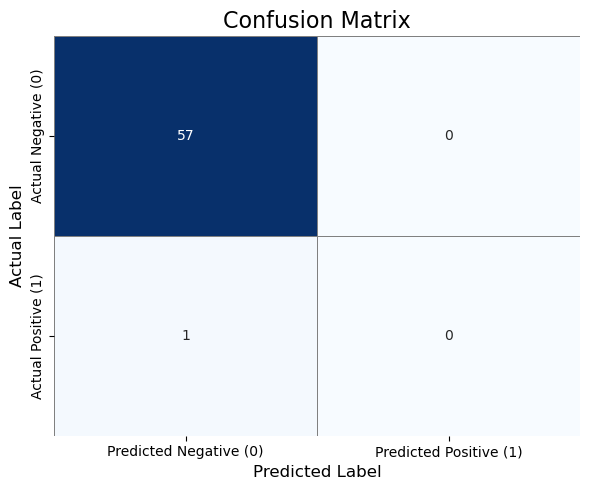

In [0]:
# Create a heatmap
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    confusion_df,
    annot=True,          
    fmt="d",            
    cmap="Blues",        
    cbar=False,          
    linewidths=0.5,    
    linecolor="gray"     
)

# Add titles and axis labels
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("Actual Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()